### Notes:   need to figure out how to querry NOAA API to get better baro correction data 
https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:61705/detail
https://www.ncei.noaa.gov/support/access-search-service-api-user-documentation
https://www.ncdc.noaa.gov/data-access
    

# ASPA-UH streamflow data processing

### Readme

This repository is the cloud-home of the UH-ASPA stream gauge project, which is currently mainteined by C. Shuler (UH) and M. Erickson (ASPA) 

The script below is designed to process stream stage data from eight stream gauges on Tutuila into useful streamflow information. For metadata and all other available information regarding these stations please see the Docs folder in this repository. 

This script is a work in progress. It is currently the most up to date version of a program designed to process raw .csv files exported from Hoboware software, but is is subject to change, revision, or removal at the developers discression.   

No guarentee is made regarding the quality or accuracy of these data.  No QA QC procedures have been applied to these data except for what is explicitly shown in the cells below. 

### Note on pre-precessing .hobo files into csvs

File naming convention

- The key issue for naming files is that they need to have the first word as the site name capitolized, with either a dash (-) or underscore ( _ ) following the name.    The current options are: 'Fagaalu', 'Leone', 'Fagasa', 'Afono', 'Nuuuli', 'Vaipito','Malota', 'Fagaitua'

HOBO files need to be processed into .csv files. 
- This can be done with the bulk file export tool in the "tools" menu on the hoboware program. 
- Note that the export tool has some parameters that can be changed in the File -> Preferances menu. 
- I would recommend looking at an existing .csv file in the "Raw_streamflow_csv" directory of this repository and modifying the hoboware parameters to match the columns exactly

### Notes about Base Data. 
The script uses two supplimentary datasets that can be added to if additional measurements are taken (so that rating curves can self-update) or if the stream gauge housing has a change in elevation, either from being physically moved or if the object it is mounted to is offset somehow ( so that the script can automatically correct for any known movements in sensor elevation). It is imperitive that these datasets are kept consistent and up to date.


### This version also has a module at the end to integrate USGS historical stream gauge data
This data is only used in this script to produce a single output file that is used as input in the SWB2 water budget model, but you could do more with it if you want.

In [7]:
# import all libraries (ensure all are listed in the environment.yml file)

from IPython.display import display, HTML    # make the screen bigger!
display(HTML(data=""" <style>    div#notebook-container    { width: 85%; }    div#menubar-container    
{ width: 85%; }    div#maintoolbar-container { width: 99%; } </style> """))     

import os
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import shutil   # use to move PDF out of the directory
import re
import datetime
from datetime import date, datetime, timedelta
from itertools import chain
import statistics as st
import copy
from sklearn.metrics import mean_squared_error
from math import sqrt
from lmfit.models import PowerLawModel
import xlrd
# additional baseflow_separation packages
import matplotlib.dates as matdates
import sys

%matplotlib notebook

### Notes on file uploads
- Tech needs to use the bulk file export option on Hoboware to get the hobo data into csv format 
- This repo has a place to back up the HOBO files - **.\\Raw_data\\Stream_gauges\\HOBO_files**   Please place HOBO files here after they have been extracted to csv
- The csv Data for both baros and stream gauges needs to be uploaded to the folder **.\\Raw_data\\Stream_gauges\\Stream_Baro_csv_files**
- Please remember naming conventions: the acceptable 

### Import custom functions

In [8]:
%run Functions/Funcs.py

In [39]:

# some path managment here


# just to be explicit about where things are, these are relative paths to the existing file tree
path_raw_data = (os.path.join("..", "Raw_data/Stream_gauges/Stream_Baro_csv_files"))

results_path = os.path.join("..", 'Results')

#CLEAN THIS UP LATER

streamflow_measurements_path = os.path.join('..', "Raw_data/Stream_gauges/FlowTracker_measurements")
other_data_path = os.path.join('..', "Raw_data/Stream_gauges/other_data")
### path_base_data =  (os.path.join("..", "Base_data"))
#path_survey_data = ("raw_data/Stream/Survey_data")
                   
   

#### Define Which Stations to analyze

In [31]:
stations = ['Fagaalu', 'Leone', 'Fagasa', 'Afono', 'Nuuuli', 'Vaipito','Malota', 'Fagaitua', 'Baro1', 'Baro2', 'Baro3']            # Station list 
stream_stations = ['Fagaalu', 'Leone', 'Fagasa', 'Afono', 'Nuuuli', 'Vaipito','Malota', 'Fagaitua']

### Read in all the csv files from junkshow different format land...

In [11]:
files = os.listdir(path_raw_data)             # list of all raw stream files
All_data = {}     # this will be a dictionary of each individual file keyed by the station name and date

for i in files: 
    print("reading: - {}".format(i))   # comment out if desired
    
    try:                                                            # try statement is incase one is messed up to figure out which is is
        data = pd.read_csv(os.path.join(path_raw_data, i))      # read each file
        
        # Fix some inconsistencies in how data gets extracted out of hoboware. THIS is where other data cleaning things might be needed
        if data.columns[0].split(" ")[0]  == "Plot":
            data = pd.read_csv(os.path.join(path_raw_data, i), skiprows=1)      # read the file in again right
            print("fixed issue with different first row")    
        if data.columns[0] == "#":             
            data.drop("#", axis=1, inplace=True)
            print("fixed issue with numeric index column")
            
        # The case where hoboware spits out a date time col instead of jsut date, AARRGG!  
        if "GMT" in data.columns[0]:        
            data = data.iloc[:,0:3]
            data.columns = ['Date and Time', 'psi', 'temp']; float_cols = ['psi', 'temp']  # define columns for processing    
        # The case where hoboware spits out separate date and time cols  
        else:                              
            data = data.iloc[:,0:4]
            data.columns = ['Date', 'Time', 'psi', 'temp']; float_cols = ['psi', 'temp']  # define columns for processing
            data['Date and Time'] = data['Date'] + ' ' + data['Time']
            del data['Date']; del data['Time'] 

        
    # data cleaning
        data['Date and Time'] = pd.to_datetime(data['Date and Time'])   # String date to real date
        data['Date and Time'] = data['Date and Time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))  # make sure each entry is on a 15 min rounded interval: note rounds down to the last 15 min interval
        for h in float_cols:                
            data[h]=data[h].astype(float)              # make sure all the data is in float form 
        
    # rename each dataframe as site, date and time
        site = i.replace("_", "-")                         # name can be anything with format name- or name_ or name" " 
        site = i.replace(" ", "-")    
        site = i.split('-')[0]
        site = site.capitalize()    # just incase any of the site names are lower case
        start = str(data['Date and Time'][0]).split(' ')[0]
        end = str(data['Date and Time'].iloc[-1]).split(' ')[0] 
        key_name = site +'_'+ start +'_'+ end
        All_data[key_name] = data      
        
    except:
        print(f"You have to look at this file {i} and fix it please!!!")


# Now that files are loaded into one dictionary, this parses that dictionary and concatinates the files from each station into one entry

All_compiled ={}                            # This will be a dictionary of all the master files, one for each station
Stream_file_list = list(All_data.keys())             # This is the list of every single file in the folder

# this code sorts out each file name for each station and stores it in a temporary list
for q in stations: 
    Temp_Dic ={}
    r = re.compile(q)                       # find things that have this substring in them
    file_list = list(filter(r.match, Stream_file_list))
    
    #Now we iterate over each file name in the temporary list for each station    
    for i in file_list:                         
        Temp_Dic[i] = All_data[i]                                          # put all the data into a temorary dictionary (note this is the only place all the station specific data is in a dictionary)
        All_compiled[q] = pd.concat(Temp_Dic.values()).drop_duplicates()    # stick them all together into a station specific master file
        All_compiled[q] = All_compiled[q].sort_values('Date and Time')       # sort by date
        All_compiled[q] = All_compiled[q].dropna(axis=0, how='all')

reading: - Afono-1_april22.csv
reading: - Afono-2-012519.csv
reading: - Afono-2-052217.csv
reading: - Afono-2-060519.csv
reading: - Afono-2-061217.csv
reading: - Afono-2-070317.csv
reading: - Afono-2-082417.csv
reading: - Afono-2_050117.csv
reading: - Afono-stream-012618.csv
reading: - Afono-stream-030918.csv
reading: - Afono-stream-061918.csv
reading: - Afono-stream-092917.csv
reading: - Afono-stream-101718.csv
reading: - Afono-stream-120418.csv
reading: - Afono-stream-120817 (2).csv
reading: - Afono-stream-120817.csv
reading: - Afono1-april22.csv
reading: - Baro1 052416 (2).csv
reading: - baro1-.csv
reading: - Baro1-012017.csv
reading: - Baro1-040617.csv
reading: - Baro1-051420.csv
fixed issue with different first row
fixed issue with numeric index column
reading: - Baro1-052317.csv
reading: - Baro1-052416.csv
reading: - baro1-060716.csv
reading: - Baro1-060919_CORRECTED.csv
reading: - Baro1-061317.csv
reading: - baro1-062016.csv
reading: - Baro1-070717.csv
reading: - Baro1-071916.cs

reading: - Vaipito-5-041216.csv
reading: - Vaipito-5-042116.csv
reading: - Vaipito-5-060517.csv
reading: - Vaipito-5-061516.csv
reading: - Vaipito-5-070517.csv
reading: - Vaipito-5-071916.csv
reading: - Vaipito-5-081916 (2).csv
reading: - Vaipito-5-081916.csv
reading: - Vaipito-5-082517.csv
reading: - Vaipito-5-100516.csv
reading: - Vaipito-5-102518.csv
reading: - Vaipito-5-111416.csv
reading: - Vaipito-5-121616.csv
reading: - Vaipito-5-82516 (2).csv
reading: - Vaipito-5-82516.csv
reading: - Vaipito-5-April.csv
reading: - Vaipito-5-April22.csv
reading: - Vaipito-5_040616.csv
reading: - Vaipito-5_042617_change_out-.csv
reading: - Vaipito-stream-012618.csv
reading: - Vaipito-stream-030618.csv
reading: - Vaipito-stream-092917.csv
reading: - Vaipito-stream-102518.csv
reading: - Vaipito-stream-120817 (2).csv
reading: - Vaipito-stream-120817.csv


<IPython.core.display.Javascript object>


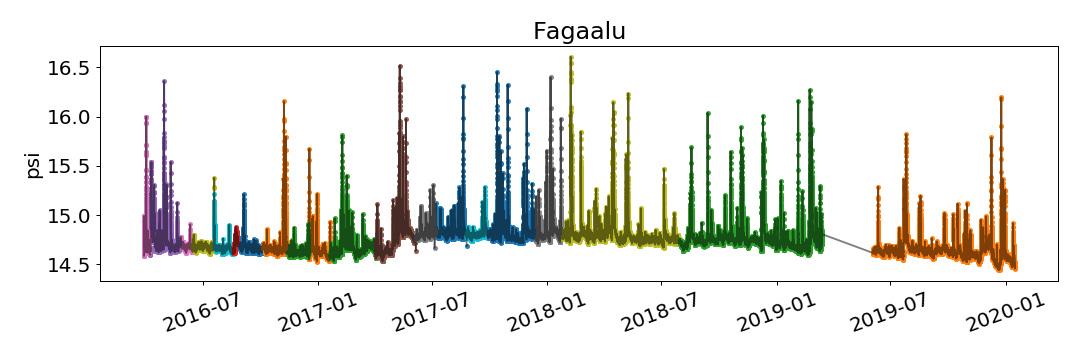

<IPython.core.display.Javascript object>


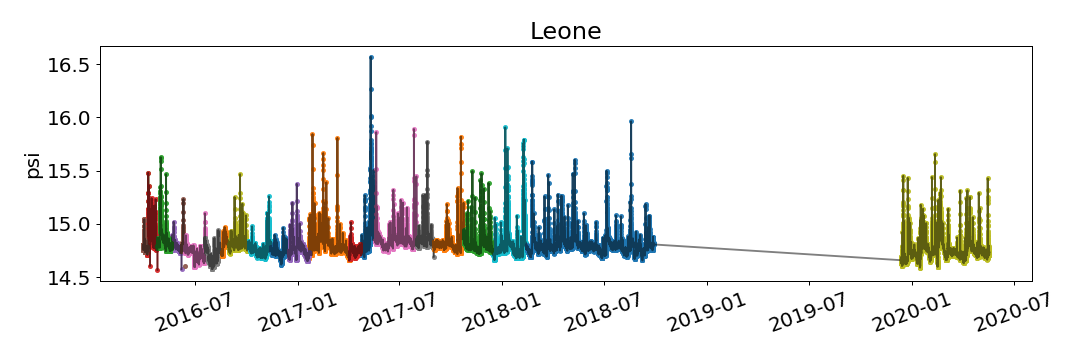

<IPython.core.display.Javascript object>


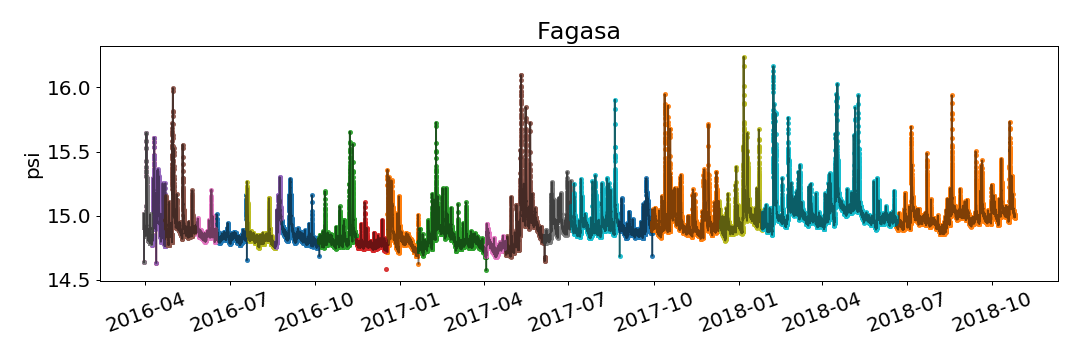

<IPython.core.display.Javascript object>


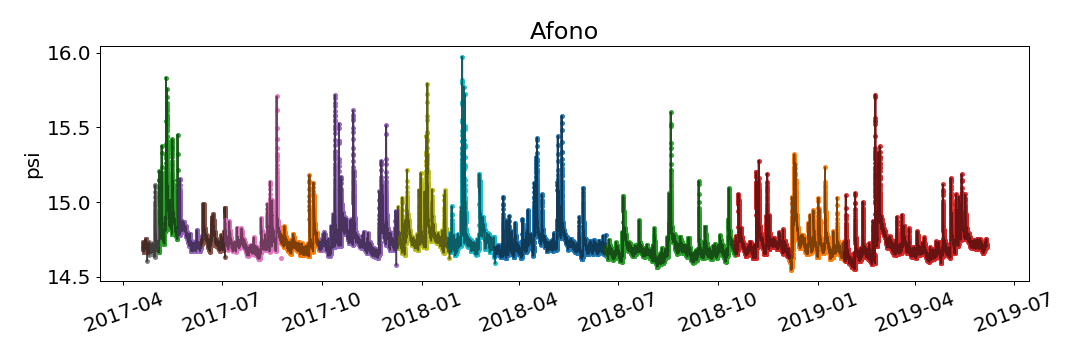

<IPython.core.display.Javascript object>


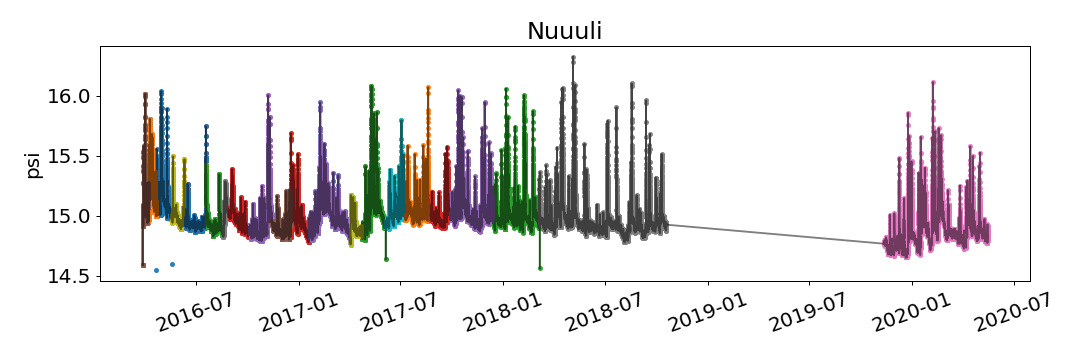

<IPython.core.display.Javascript object>


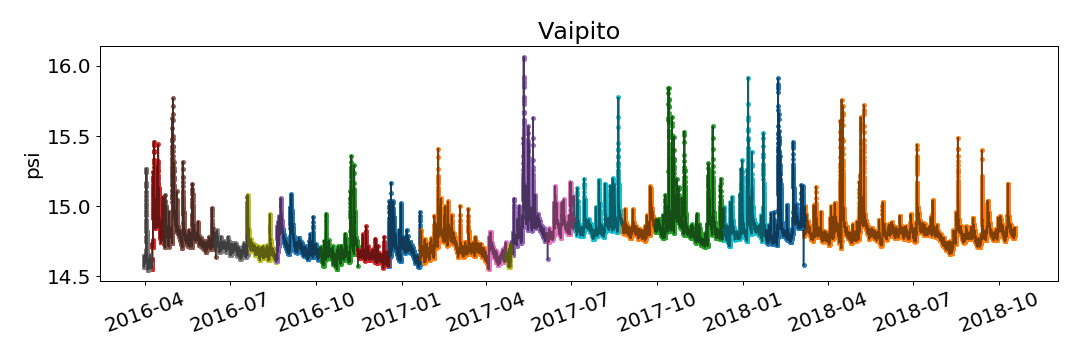

<IPython.core.display.Javascript object>


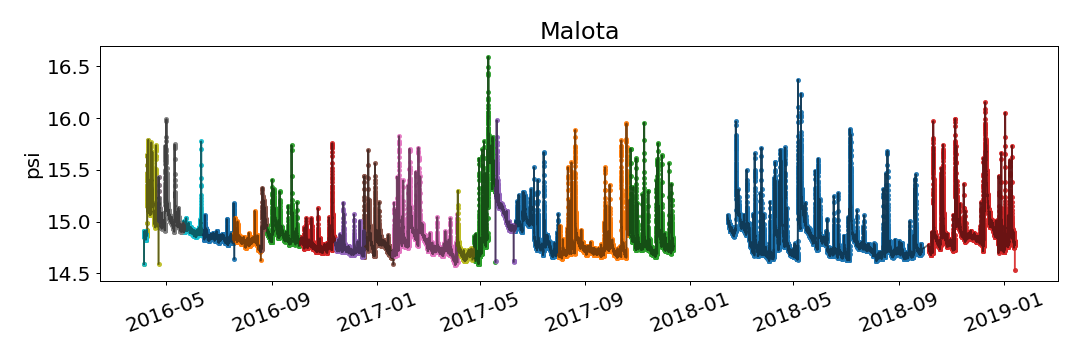

<IPython.core.display.Javascript object>


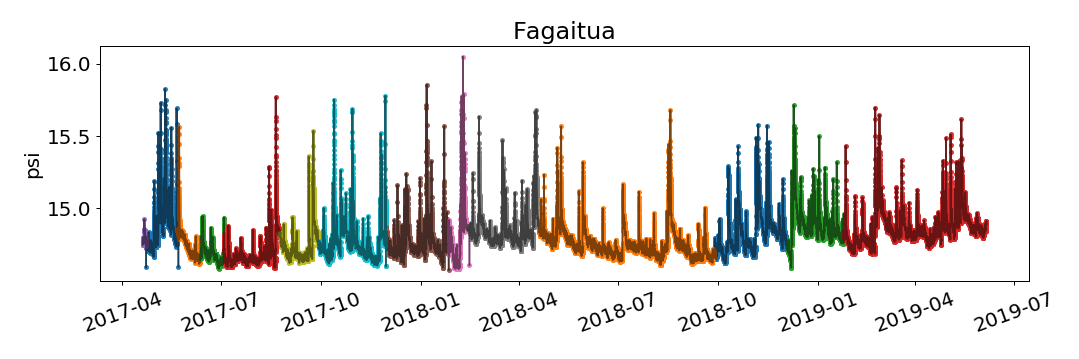

<IPython.core.display.Javascript object>


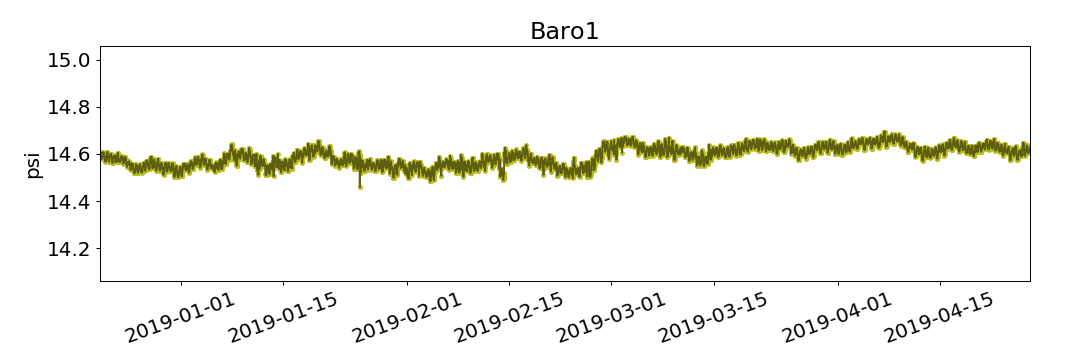

<IPython.core.display.Javascript object>


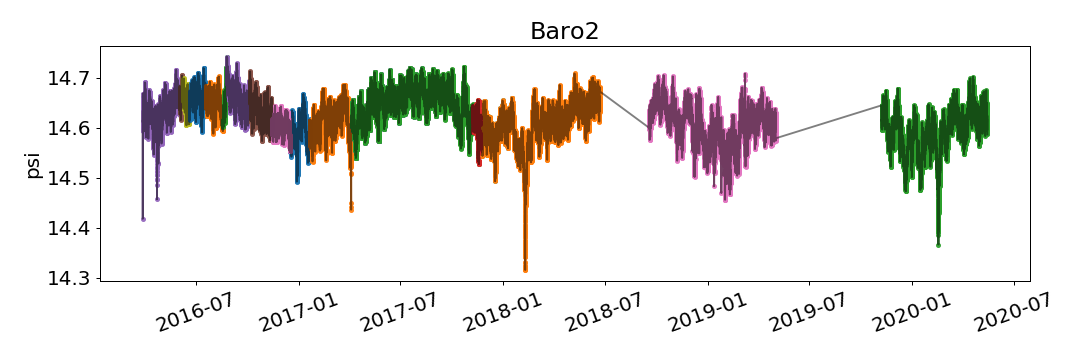

<IPython.core.display.Javascript object>


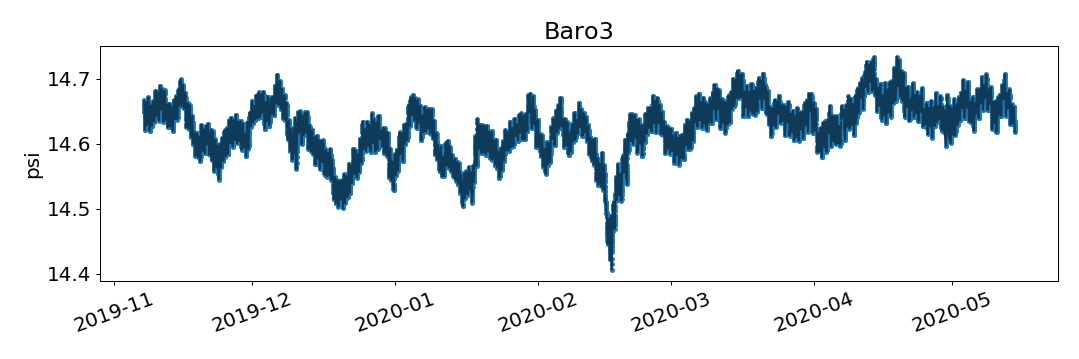

In [12]:
# Plot all data files

plt.close("all")  # close previous figures to clear memory
matplotlib.rcParams.update({'font.size': 16})

for q in stations:
    fig = plt.figure(figsize=(12, 4))
    ax1 = plt.axes()
    ax1.set_ylabel('psi', color='k')
    ax1.set_title(q)
        
    Temp_Dic ={}                              # prepare to plot each dataset by station
    r = re.compile(q)                         # find things that have this substring in them
    file_list = list(filter(r.match, Stream_file_list)) # list of files that correspond to station q only
    
    for i in file_list:
        plt.plot(All_data[i]['Date and Time'], All_data[i]['psi'], alpha = .9, label=i, marker='.')  # ploet each file in color
        
    plt.plot(All_compiled[q]['Date and Time'], All_compiled[q]['psi'], alpha = .5, color='k')     # plot the concatinated dataset in black
    
    plt.xticks(rotation=20)
    plt.tight_layout()

# Baro correction routine
This subtracts the atmos. pressure reading from the barometer from the reading from the stream gauge PT to get the actual water head (im m above the PT) in the stream 

In [13]:
# average All baro readings 
baro_names = ['Baro1', 'Baro2', 'Baro3']
Baro_merged = pd.DataFrame(columns =['Date and Time', 'baros_psi_ave'])
for idx, baro in enumerate(baro_names):
    bdata = All_compiled[baro]
    bdata = bdata.rename(columns={'psi': f'psi_{idx}'})
    Baro_merged = Baro_merged.merge(bdata, how='outer', on='Date and Time')
    Baro_merged['baros_psi_ave'] = Baro_merged[['baros_psi_ave', f'psi_{idx}']].mean(axis=1)     # Do the averaging of each baro timeseries

Baro_aves = Baro_merged[['Date and Time', 'baros_psi_ave']]    # Cut out extranious cols
Baro_aves.sort_values('Date and Time', inplace=True)

All_masters ={}   
for q in stations:    
    # this is the baro correction routine     
    merger = All_compiled[q].merge(Baro_aves, how='inner', on='Date and Time') # this sticks the baro data onto the station master data and lines up the dates
    merger['corrected_H2O_level'] = (merger['psi'] -  merger['baros_psi_ave'])*0.703070   # The correction is simple,  0.703070 is the conversion between PSI and m of water head
    All_masters[q] = merger
    All_masters[q] = All_masters[q].dropna(subset = ['corrected_H2O_level'], axis=0, how='any') # somehow the merge added duplicate dates remove entries with double dates take the    

<ipython-input-13-c2ed93fbd0a2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Baro_aves.sort_values('Date and Time', inplace=True)


<IPython.core.display.Javascript object>


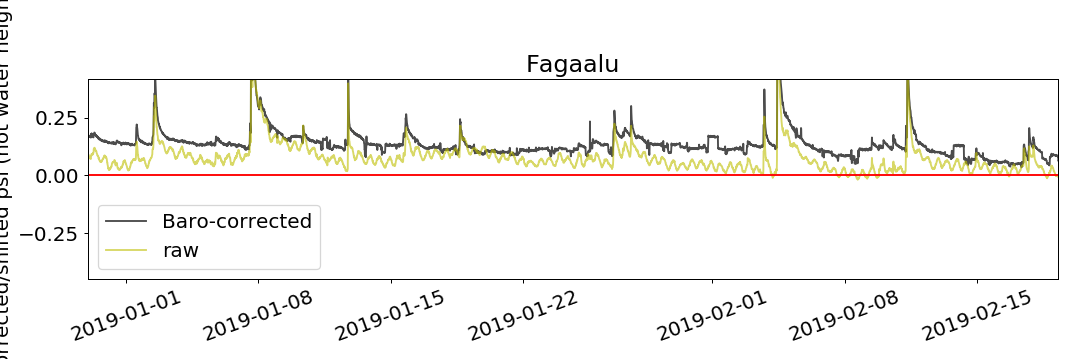

<ipython-input-14-b761900bccae>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


<IPython.core.display.Javascript object>


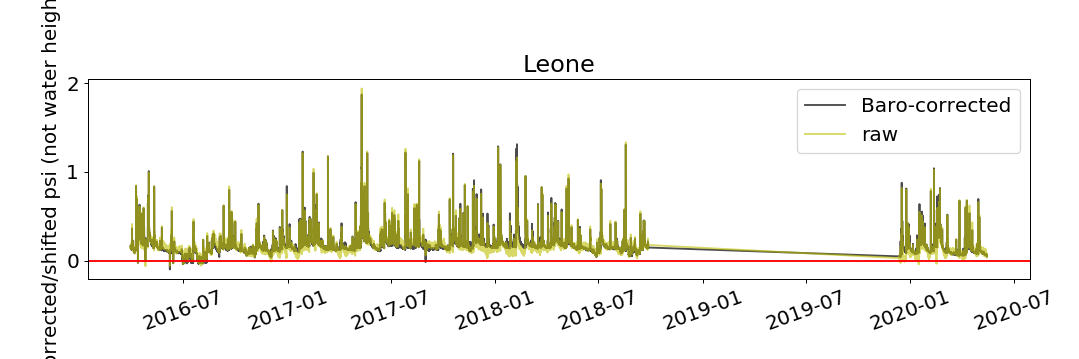

<ipython-input-14-b761900bccae>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


<IPython.core.display.Javascript object>


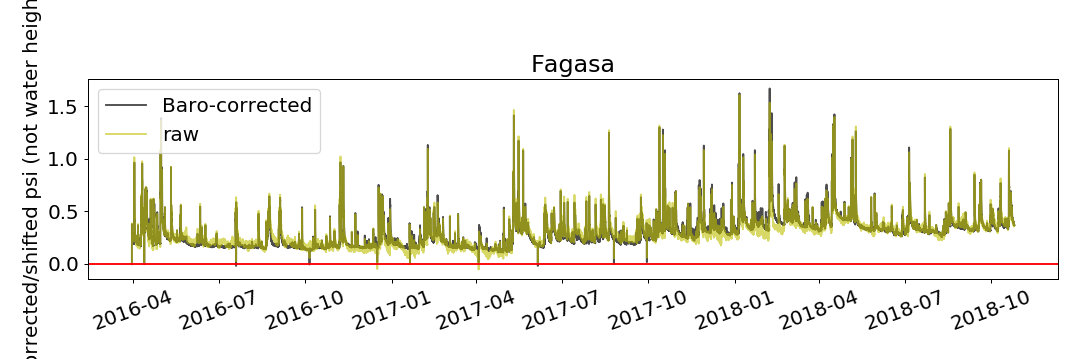

<IPython.core.display.Javascript object>


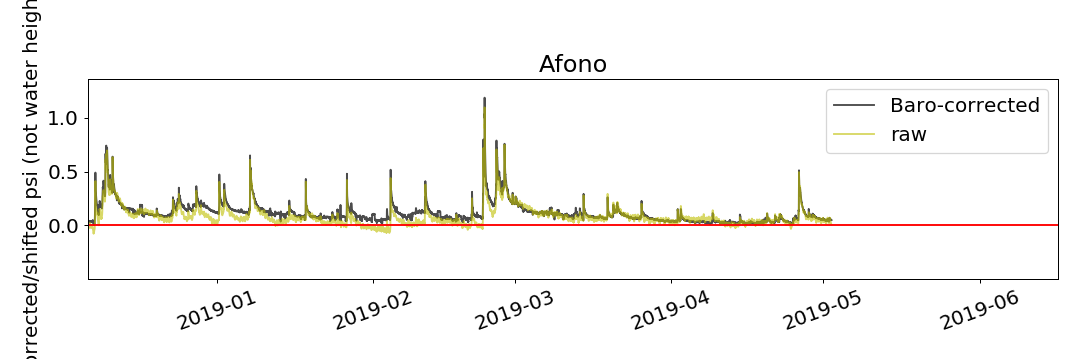

<IPython.core.display.Javascript object>

<ipython-input-14-b761900bccae>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


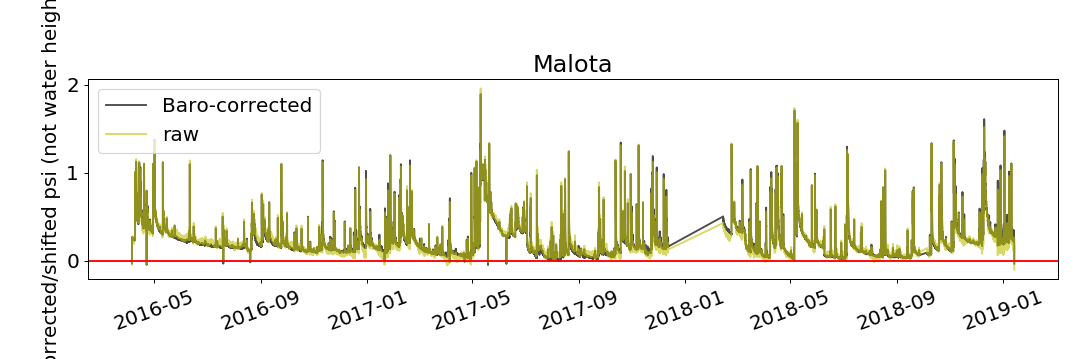

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


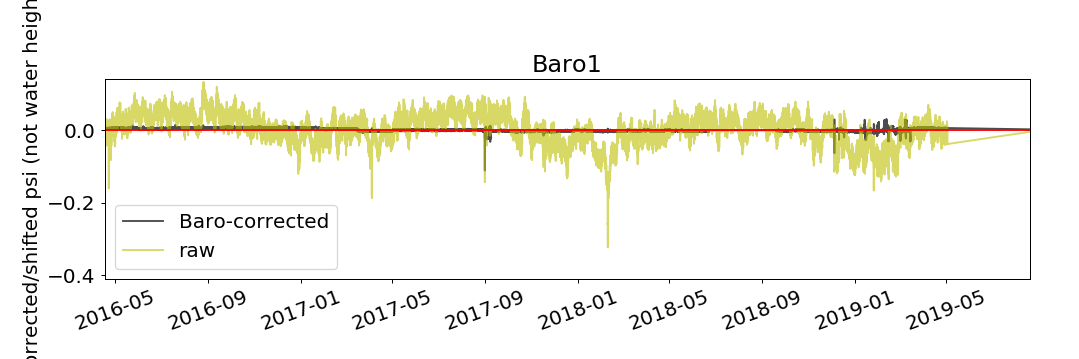

<ipython-input-14-b761900bccae>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


<IPython.core.display.Javascript object>


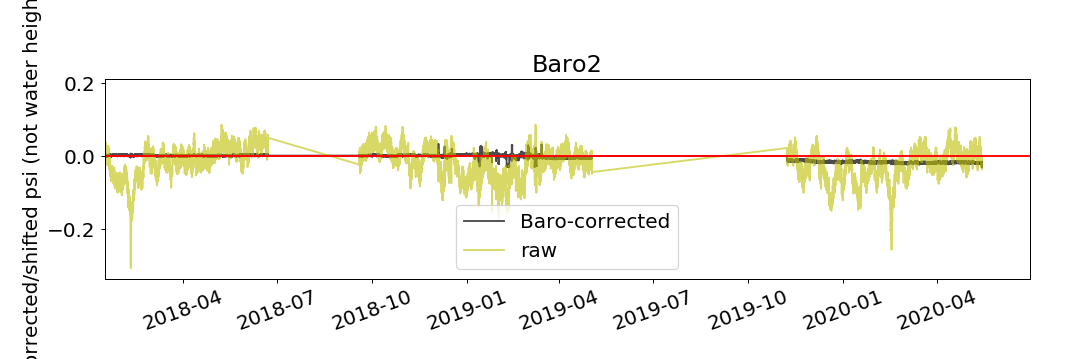

<ipython-input-14-b761900bccae>:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


<IPython.core.display.Javascript object>

In [14]:
# plots the results of above cell
plt.close("all")  # close previous figures to clear memory

for q in stations:
    fig = plt.figure(figsize=(12, 4))
    ax1 = plt.axes()
    plt.plot(All_masters[q]['Date and Time'], (All_masters[q]['psi'] -  All_masters[q]['baros_psi_ave']), alpha = .7, color='k', label="Baro-corrected")   # note this plot is in 
    plt.plot(All_masters[q]['Date and Time'], All_masters[q]['psi']-All_masters[q]['baros_psi_ave'].mean(), alpha = .6, color='y', label="raw")   # Master['psi']-merger['psi'].mean() is the average baro psi value for comparison
    plt.axhline(y=0, color='r', linestyle='-')                      # just plotting the 0 point, if negative the logger was obviously pretty close to no water
    ax1.set_ylabel('corrected/shifted psi (not water height)', color='k')
    plt.legend()
    ax1.set_title(q)
    
    plt.xticks(rotation=20)
    plt.tight_layout()
# note data that falls below the red line is essentially below measurement ability. Need to define some kind of minimum flow value to apply to these flows

#### Interesting plotting:  Check how the actual baro data compares to the stream gauge data. 
If the colored line (baro data) and the grey line (stream data) are matching that means the logger was dry. Oops.

<IPython.core.display.Javascript object>


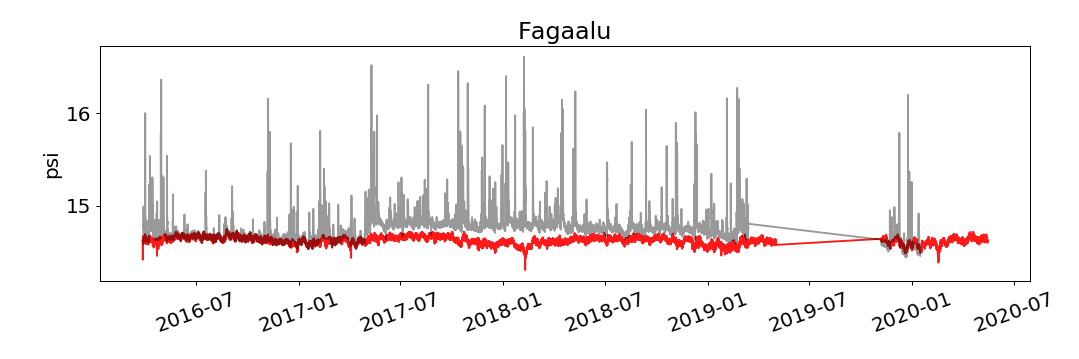

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


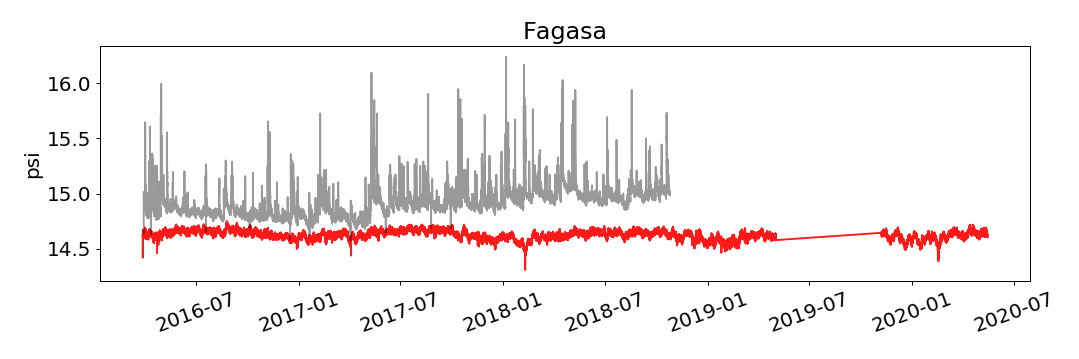

<IPython.core.display.Javascript object>


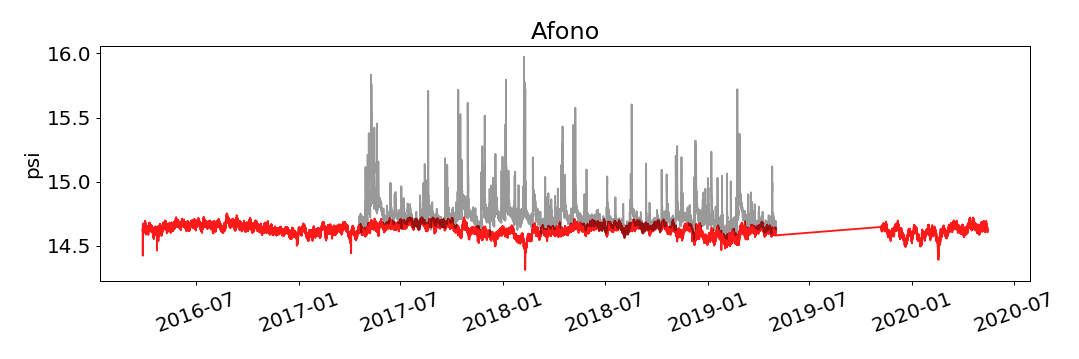

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


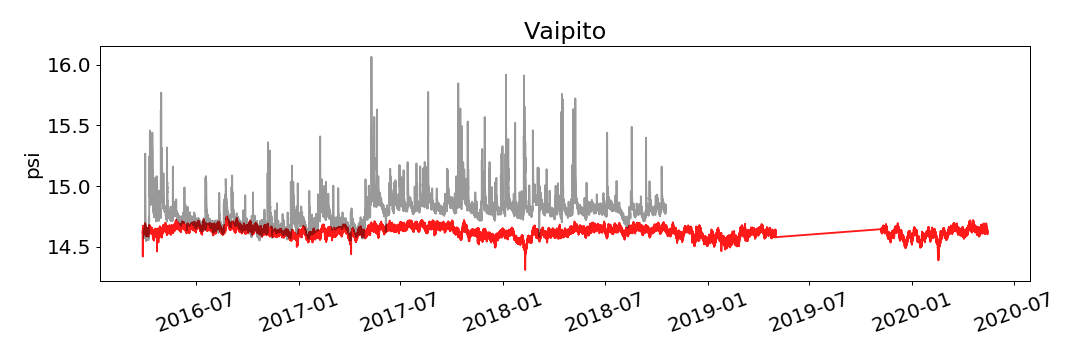

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


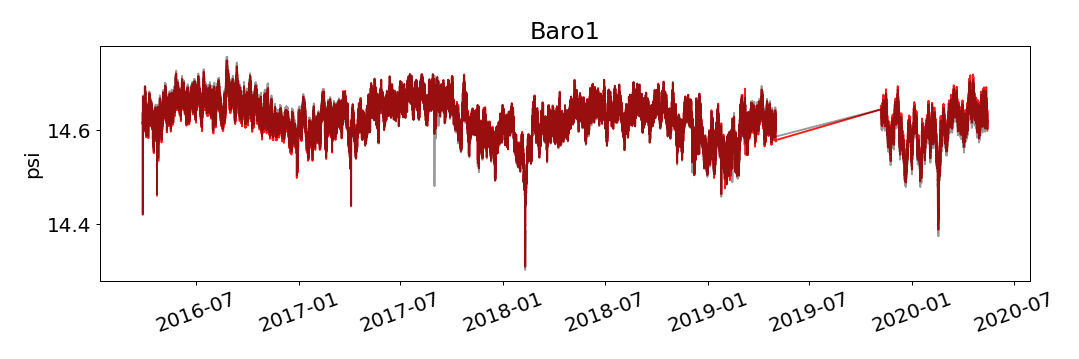

<IPython.core.display.Javascript object>


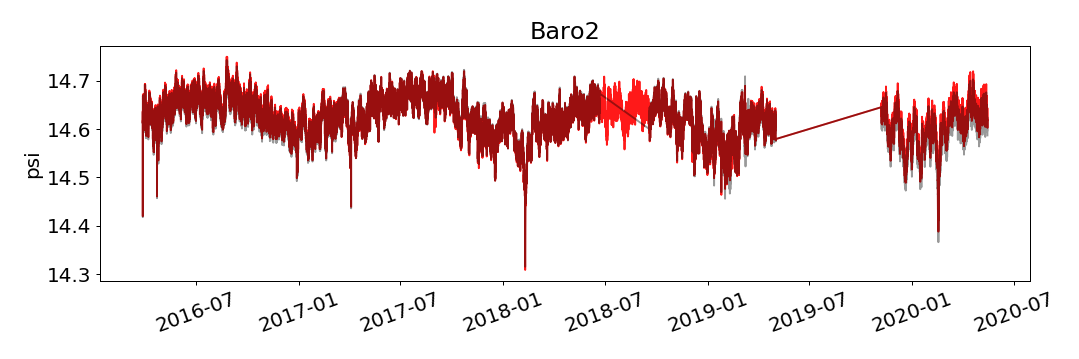

<IPython.core.display.Javascript object>


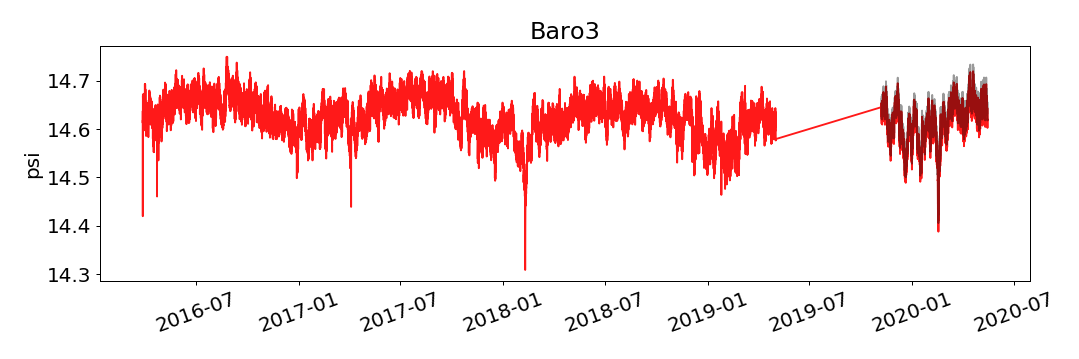

In [16]:
plt.close("all")  # close previous figures to clear memory

for q in stations:
    fig = plt.figure(figsize=(12, 4))
    ax1 = plt.axes()
    ax1.set_ylabel('psi', color='k')
    plt.plot(Baro_aves['Date and Time'], Baro_aves['baros_psi_ave'], alpha = .9,color='r')
    plt.plot(All_masters[q]['Date and Time'], All_masters[q]['psi'], alpha = .4, color='k', label='streamdata')
    ax1.set_title(q)
    
    
    plt.xticks(rotation=20)
    plt.tight_layout()

# Out of water bad data point removal algorithum
Since the loggers are still recording when they are changed out sometimes they record data when they are in the air. 
This cell finds those data points and removes them. (plotted as red dots below)


<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>

[Timestamp('2016-11-17 10:45:00'), Timestamp('2017-06-05 12:45:00'), Timestamp('2017-07-05 11:15:00'), Timestamp('2017-08-25 10:30:00'), Timestamp('2019-11-07 10:30:00'), Timestamp('2019-12-17 17:45:00'), Timestamp('2019-12-23 14:45:00'), Timestamp('2019-12-24 16:15:00'), Timestamp('2020-01-12 10:45:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


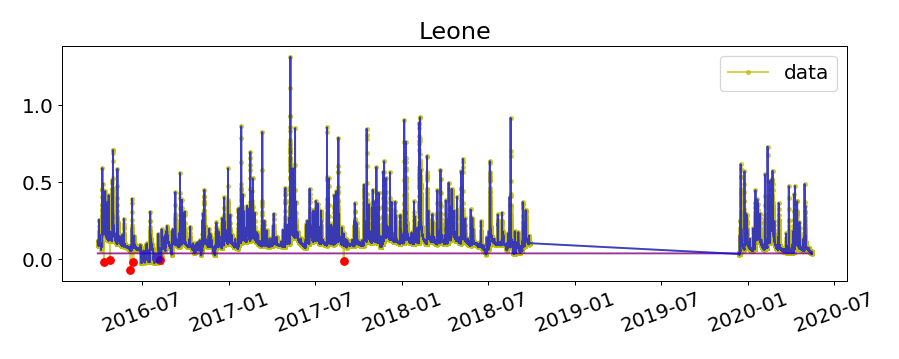

[Timestamp('2016-04-12 09:45:00'), Timestamp('2016-04-25 16:30:00'), Timestamp('2016-06-07 13:45:00'), Timestamp('2016-06-13 14:30:00'), Timestamp('2016-08-08 19:45:00'), Timestamp('2017-08-31 08:45:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


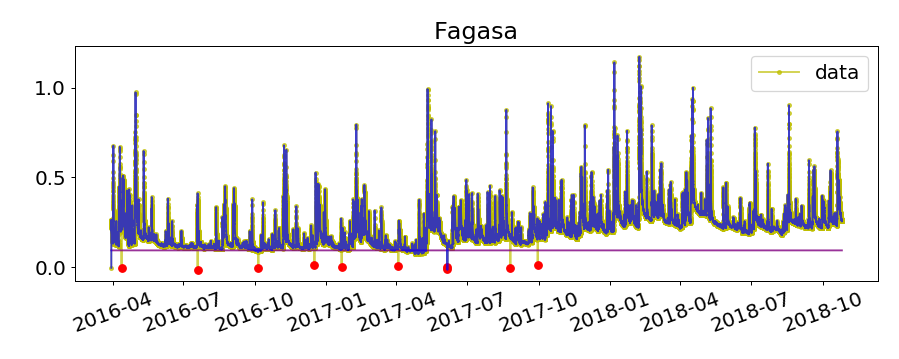

[Timestamp('2016-04-12 13:45:00'), Timestamp('2016-07-19 08:30:00'), Timestamp('2016-10-05 11:00:00'), Timestamp('2016-12-16 13:00:00'), Timestamp('2017-01-20 09:30:00'), Timestamp('2017-04-03 10:00:00'), Timestamp('2017-06-05 09:15:00'), Timestamp('2017-06-05 10:45:00'), Timestamp('2017-08-25 09:15:00'), Timestamp('2017-09-29 11:30:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


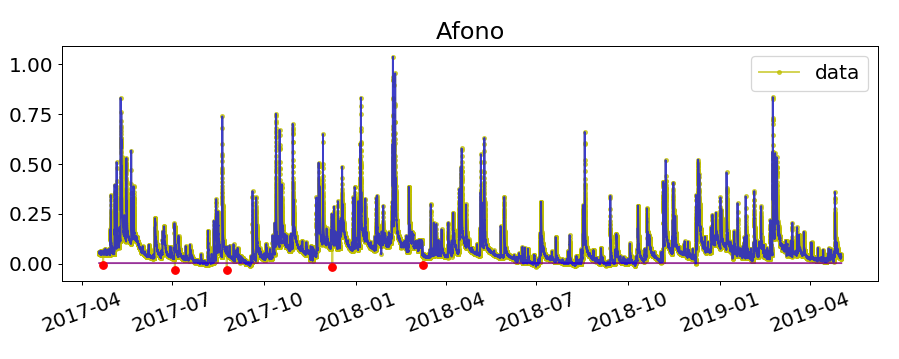

[Timestamp('2017-04-22 17:30:00'), Timestamp('2017-07-03 13:00:00'), Timestamp('2017-08-24 13:30:00'), Timestamp('2017-12-08 10:15:00'), Timestamp('2018-03-09 13:45:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>

[Timestamp('2016-03-28 15:00:00'), Timestamp('2016-04-21 17:30:00'), Timestamp('2016-05-19 15:00:00'), Timestamp('2017-06-05 13:15:00'), Timestamp('2018-03-07 12:15:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


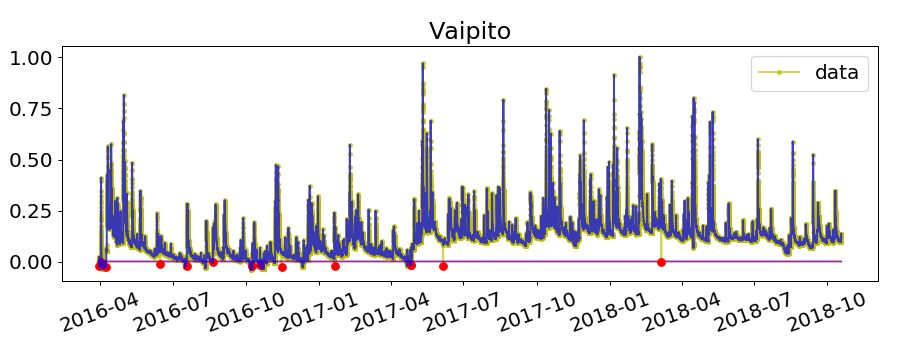

[Timestamp('2016-03-30 15:45:00'), Timestamp('2016-04-01 23:30:00'), Timestamp('2016-04-08 12:15:00'), Timestamp('2016-06-15 11:30:00'), Timestamp('2016-07-19 09:00:00'), Timestamp('2016-08-20 07:30:00'), Timestamp('2016-10-09 01:00:00'), Timestamp('2016-10-18 15:30:00'), Timestamp('2016-11-14 13:45:00'), Timestamp('2017-01-20 09:45:00'), Timestamp('2017-04-26 13:15:00'), Timestamp('2017-04-26 14:15:00'), Timestamp('2017-06-05 12:00:00'), Timestamp('2018-03-06 10:15:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


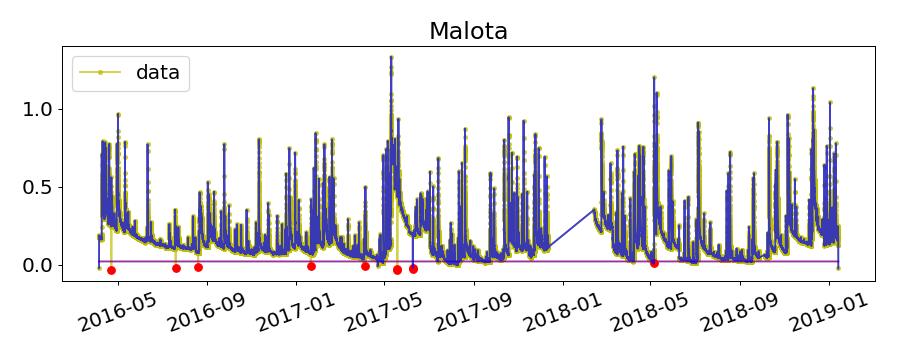

[Timestamp('2016-04-22 09:45:00'), Timestamp('2016-07-19 11:45:00'), Timestamp('2016-08-19 09:45:00'), Timestamp('2017-01-20 13:15:00'), Timestamp('2017-04-05 09:15:00'), Timestamp('2017-05-19 10:15:00'), Timestamp('2017-05-19 10:30:00'), Timestamp('2017-06-09 13:15:00'), Timestamp('2017-06-09 14:45:00'), Timestamp('2018-05-05 16:00:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


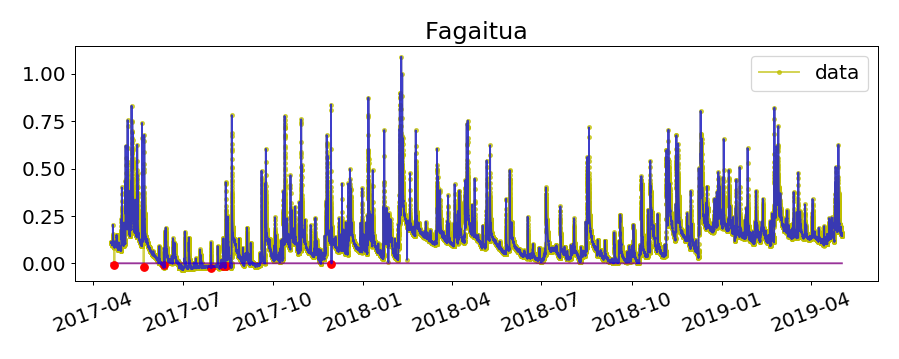

[Timestamp('2017-04-22 16:15:00'), Timestamp('2017-05-22 10:45:00'), Timestamp('2017-06-11 22:15:00'), Timestamp('2017-07-29 23:30:00'), Timestamp('2017-08-11 11:45:00'), Timestamp('2017-08-13 22:45:00'), Timestamp('2017-11-29 13:00:00')]


<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


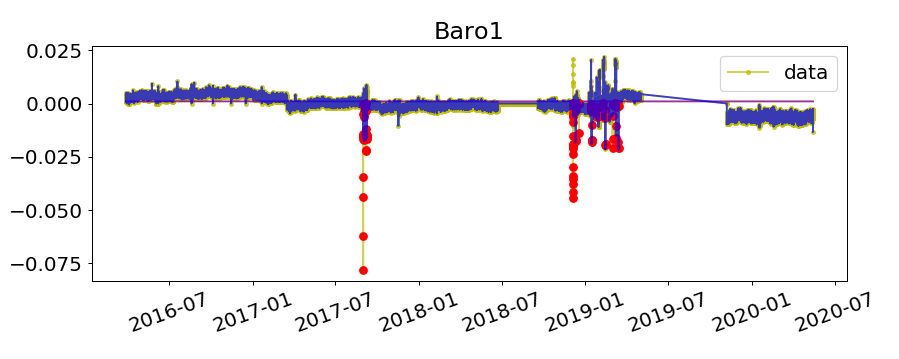

[Timestamp('2017-08-31 07:45:00'), Timestamp('2017-08-31 08:00:00'), Timestamp('2017-08-31 08:30:00'), Timestamp('2017-08-31 09:30:00'), Timestamp('2017-08-31 09:45:00'), Timestamp('2017-08-31 10:00:00'), Timestamp('2017-08-31 10:15:00'), Timestamp('2017-08-31 10:30:00'), Timestamp('2017-08-31 11:00:00'), Timestamp('2017-08-31 16:45:00'), Timestamp('2017-08-31 17:00:00'), Timestamp('2017-08-31 18:45:00'), Timestamp('2017-08-31 20:00:00'), Timestamp('2017-09-01 07:00:00'), Timestamp('2017-09-01 16:45:00'), Timestamp('2017-09-01 17:00:00'), Timestamp('2017-09-01 17:15:00'), Timestamp('2017-09-01 18:15:00'), Timestamp('2017-09-01 18:30:00'), Timestamp('2017-09-01 20:30:00'), Timestamp('2017-09-01 20:45:00'), Timestamp('2017-09-05 07:15:00'), Timestamp('2017-09-05 16:45:00'), Timestamp('2017-09-05 17:00:00'), Timestamp('2017-09-05 19:15:00'), Timestamp('2017-09-05 20:45:00'), Timestamp('2017-09-05 21:00:00'), Timestamp('2017-09-06 07:00:00'), Timestamp('2017-09-06 16:45:00'), Timestamp('20

<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified)


<IPython.core.display.Javascript object>


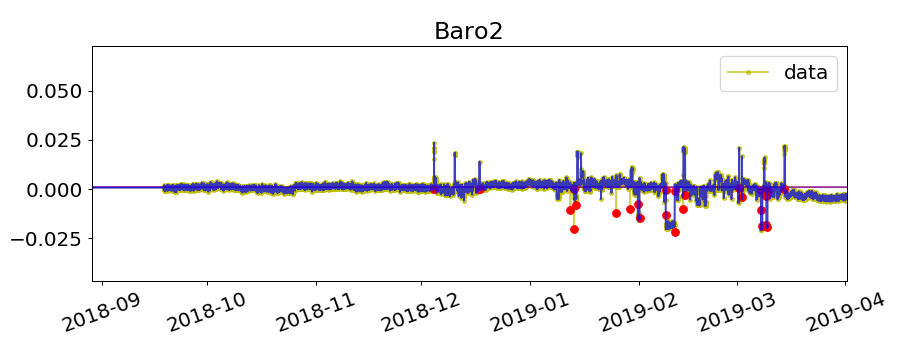

[Timestamp('2017-08-31 07:45:00'), Timestamp('2017-08-31 08:45:00'), Timestamp('2017-08-31 09:15:00'), Timestamp('2017-08-31 10:45:00'), Timestamp('2017-08-31 11:15:00'), Timestamp('2017-08-31 19:00:00'), Timestamp('2017-08-31 19:45:00'), Timestamp('2017-09-01 07:15:00'), Timestamp('2017-09-01 16:30:00'), Timestamp('2017-09-05 07:30:00'), Timestamp('2017-09-05 16:45:00'), Timestamp('2017-09-05 19:30:00'), Timestamp('2017-09-06 07:15:00'), Timestamp('2017-09-07 07:15:00'), Timestamp('2017-09-07 13:15:00'), Timestamp('2017-09-07 14:15:00'), Timestamp('2017-09-07 17:30:00'), Timestamp('2017-09-07 19:00:00'), Timestamp('2017-09-07 20:00:00'), Timestamp('2017-09-08 07:15:00'), Timestamp('2018-12-04 17:00:00'), Timestamp('2018-12-04 18:00:00'), Timestamp('2018-12-17 16:15:00'), Timestamp('2018-12-17 16:45:00'), Timestamp('2019-01-12 14:30:00'), Timestamp('2019-01-13 13:45:00'), Timestamp('2019-01-13 14:00:00'), Timestamp('2019-01-14 07:00:00'), Timestamp('2019-01-25 16:00:00'), Timestamp('20

<ipython-input-17-2a662895198c>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
<ipython-input-17-2a662895198c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  All_masters[q]['baseline_val'] = baseline
<ipython-input-17-2a662895198c>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  All_masters[q]['run_std'] = All_masters[q]['corrected_H2O_level'].rolling(window=3, center=True).std()  # here is our rolling 3 value std plot
<ipython-input-17-2a6

<IPython.core.display.Javascript object>


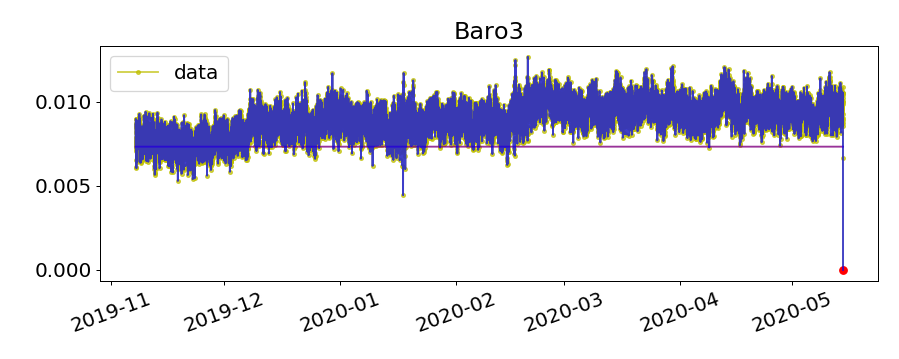

[Timestamp('2020-05-14 14:00:00')]


In [17]:
plt.close("all")  # close previous figures to clear memory
All_masters_clean = {}    #make a new dataframe for the data cleaned of download outliers

for q in stations: 
# this generates a baseline value that is defined as a quartile of the medians of 100 evenly spaced sample bins of the data set
    bin_size = round(len(All_masters[q]['corrected_H2O_level'])/100)
    da_meeds = []
    ind = 0
    for i in range(1,101): 
        win = All_masters[q]['corrected_H2O_level'][int(ind) : int(i*bin_size)]
        ind = ind + bin_size
        m = np.median(win)
        da_meeds.append(m)
    baseline = np.percentile(da_meeds, 1) # the percentile can change this number out if want to dial it in     
    
# and it doesn't work if the baseline is below zero. in this case just set the baseline to a small nunmber  
    if baseline > 0:
        All_masters[q]['baseline_val'] = baseline
    else:
        All_masters[q]['baseline_val'] = .001
            
# the algoruthim will look for values that are below the baseline, and also show up as spikes in a standard deviation plot. 

    All_masters[q]['run_std'] = All_masters[q]['corrected_H2O_level'].rolling(window=3, center=True).std()  # here is our rolling 3 value std plot
    
    bad = (All_masters[q]['corrected_H2O_level']-All_masters[q]['baseline_val'])/All_masters[q]['baseline_val'] < -.5   # now we flag values that are a a standardized amount below the baseline value
    bad_selected = All_masters[q][bad]
    
    also_bad = All_masters[q]['run_std']/All_masters[q]['run_std'].mean() > 10      # and from that set select values that also correspond with sdt sppikes, meaning they are anomolous 
    final_bad = bad_selected[also_bad]                                              # here is the data frame of just bad values (they are not gotten rid of yet only identified) 
       
#can plot the bad values on the data to see what it selected  de comment this out if 
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.axes()
    plt.plot(All_masters[q]['Date and Time'], All_masters[q]['corrected_H2O_level'] , alpha = .7, color='y', label="data",  marker = '.')
    ax1.plot(All_masters[q]['Date and Time'], All_masters[q]['baseline_val'], linestyle='-', color='purple', alpha=.8)
    plt.plot(final_bad['Date and Time'], final_bad['corrected_H2O_level'], color='r', linestyle='None', marker='o')   # note this plot is in 
    plt.title(q)
    plt.legend()

# if it seems like the computer selected the right values lets get rid of them
    drops = final_bad['Date and Time'].tolist()          #this is the list of bad dates to drop
    print(drops)
    All_masters_clean[q] =  All_masters[q][~All_masters[q]['Date and Time'].isin(drops)].copy()  # the little ~ means the opposite of, so this will KEEP all the points that are not in the drops list (also looks like the code just deletes the whole row, does not make it NAN or anything)
# again can plot to see if its all good.   
    plt.plot(All_masters_clean[q]['Date and Time'], All_masters_clean[q]['corrected_H2O_level'] , alpha = .7, color='b', label="Clean_data")
    All_masters_clean[q]['Date and Time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
    
    plt.xticks(rotation=20)
    plt.tight_layout()

# Rating curve preparation
this cell takes the manual flow measurements and sticks them on to the master files as a separate column
Note that red dots indicate date and relative flow of streamflow measurement, but plotted on a different axis as to streamflow so it should not match


<IPython.core.display.Javascript object>


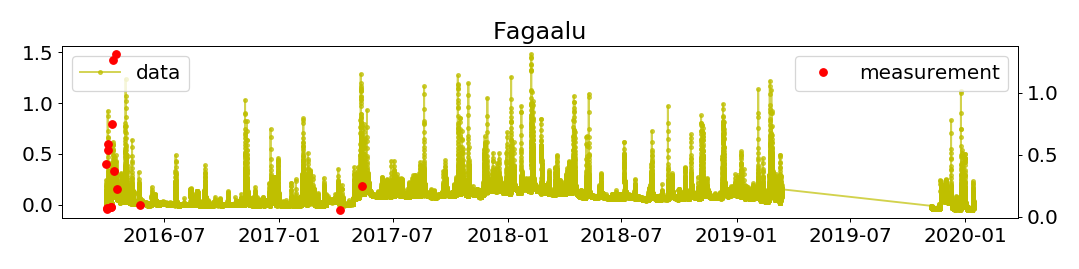

<IPython.core.display.Javascript object>


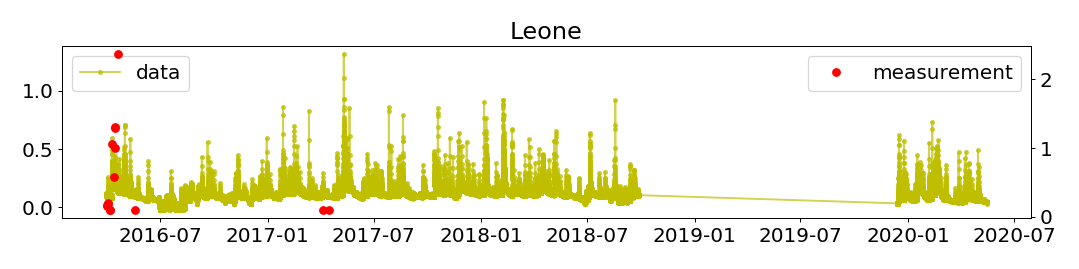

<IPython.core.display.Javascript object>


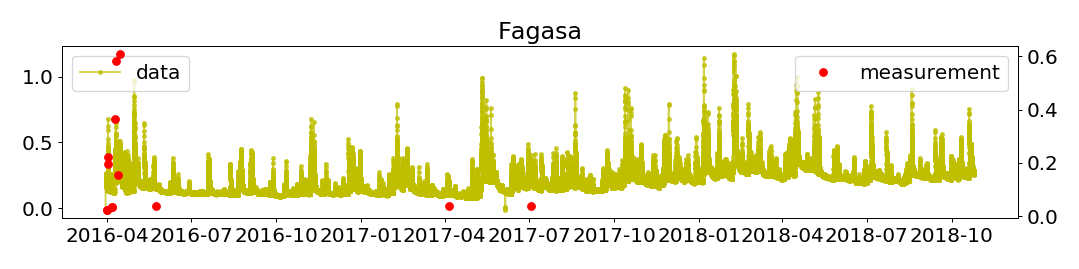

<IPython.core.display.Javascript object>


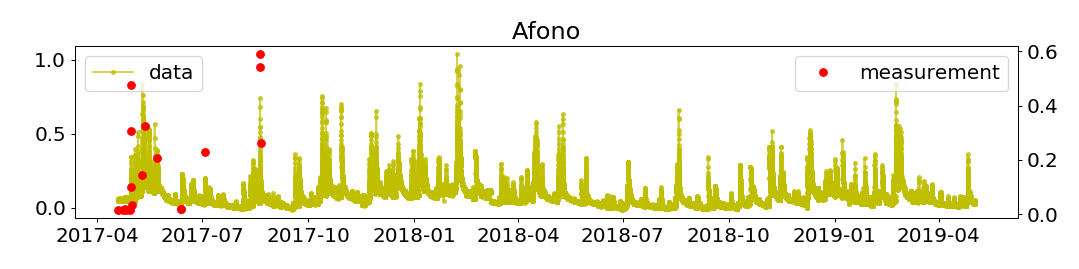

<IPython.core.display.Javascript object>


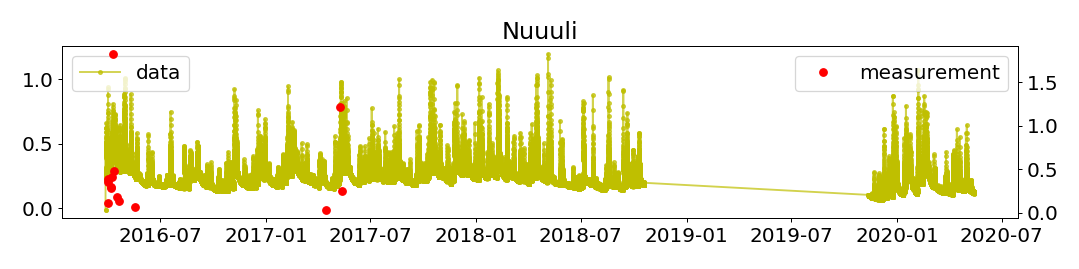

<IPython.core.display.Javascript object>


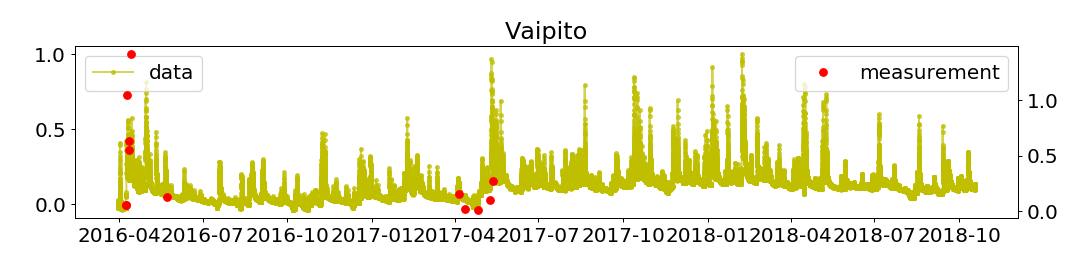

<IPython.core.display.Javascript object>


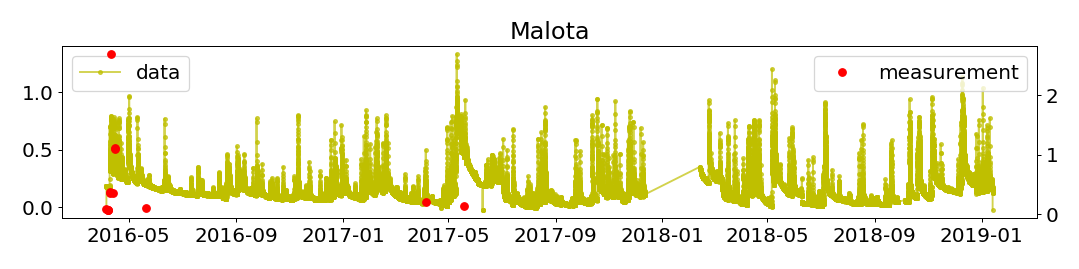

<IPython.core.display.Javascript object>


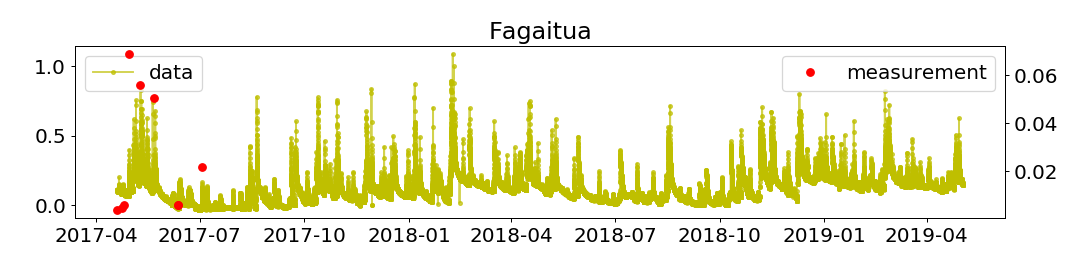

<IPython.core.display.Javascript object>


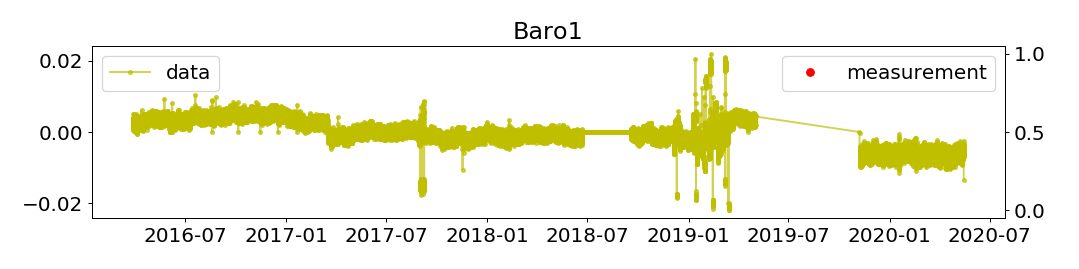

<IPython.core.display.Javascript object>


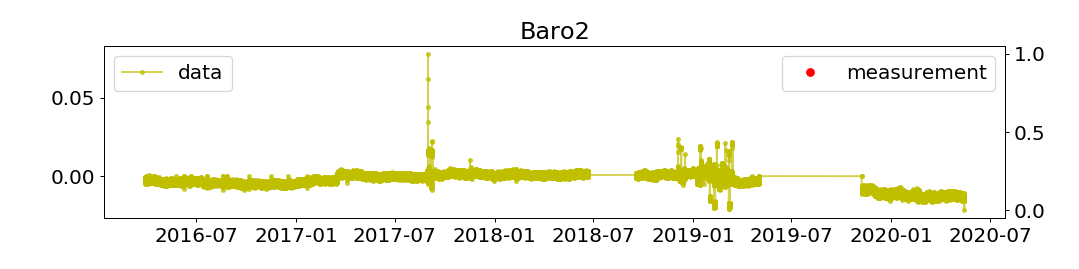

<IPython.core.display.Javascript object>


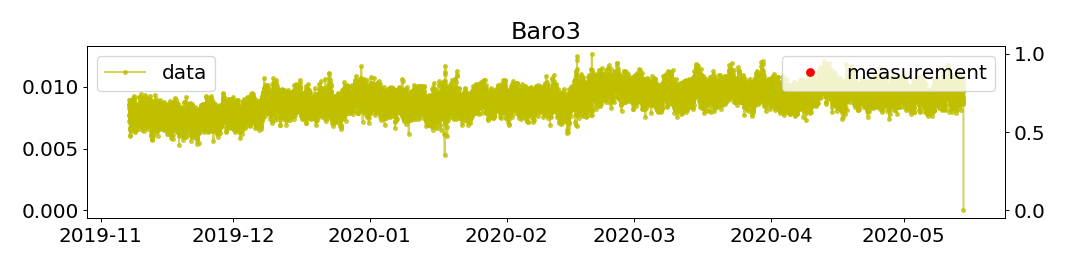

In [21]:
plt.close("all")  # close previous figures to clear memory

flo = pd.read_csv(os.path.join(streamflow_measurements_path, 'Flow_measurements.csv'))   #read the flow measurements file Change name if it is different

#basic cleaning 
flo['Date and Time'] = pd.to_datetime(flo['Date and Time'])   #date to dates
float_cols = ['Q_m3ps', 'Staff_reading']
 # and also make sure all the data is in float form
for h in float_cols:
    flo[h]=flo[h].astype(float)
flo['Site'] = flo['Site'].apply(lambda x: x.strip()) # delete any eronious spaces before or after names

# this takes the times and rounds them DOWN to the last 15 min interval point.  
flo['Date and Time'] = flo['Date and Time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))

# this block turns the consolodated measurement dataframe into a dict of each sites measurements
flo_sites = {}
for y in stations:
    current_sta = flo['Site'] == y
    isolated_dat = flo[current_sta] 
    flo_sites[y] = isolated_dat

# merge in the measurement data to the master files for each station
All_masters_flow = {}
for p in stations: 
    All_masters_flow[p] = All_masters_clean[p].merge(flo_sites[p], how='left', on='Date and Time')
    
   #can plot where the values line up with dates and relative magnitudes, NOTE red dots are on own axis not same as yellow line
    fig = plt.figure(figsize=(12, 3))
    ax1 = plt.axes()
    plt.plot(All_masters_flow[p]['Date and Time'], All_masters_flow[p]['corrected_H2O_level'] , alpha = .7, color='y',  marker = '.', label="data")
    #ax1.plot(All_masters_flow[p]['Date and Time'], All_masters_flow[p]['baseline_val'], linestyle='-', color='purple', alpha=.8)
    
    ax2 = ax1.twinx()
    ax2.plot(All_masters_flow[p]['Date and Time'], All_masters_flow[p]['Q_m3ps'], color='r', linestyle='None', marker='o', label='measurement')   # note this plot is in 
    plt.title(p)
    ax2.legend() 
    ax1.legend(loc=2)
    
    plt.xticks(rotation=20)
    plt.tight_layout()

# RE-defining the datum point for the PT location based on stream geometry
### This cell  takes the data and adds in any needed corrections to put the zero point at a location 10 m below the datums (usually bridge top)
Note that the Instrument_elevations_corrections.xlsx needs to have the different periods logged in with starts and ends except the last one which is blank, and will automatically be updateNd to the latest downloaded measurement 

Note also that the Instrument_elevations_corrections.xlsx is the sheet that needs to be updated if a PT housing or zero point is moved from some reason

In [32]:
All_masters_adjusted = {}      # new dictionary with the PT zero point defined in reference to the datum instead of zero 

for i in stream_stations: 
    try:
        Selected_master_flow = All_masters_flow[i].copy()             # load a copy of the master flow file
        inst_elevations = os.path.join(other_data_path, 'Instrument_elevations_corrections.xlsx')        # this is the file with the data of sensor distance below dataum 
        distances = pd.read_excel(inst_elevations, i, index_col=None)                             # read xlsx to memory  
        if pd.isnull(distances["End"].iloc[-1]):                                                  # here we account for the end of the last section, because it ends at the end of the data
            distances["End"].iloc[-1] = Selected_master_flow['Date and Time'].iloc[-1]            # End now equald end of all data
            
        number_of_sections = sum(pd.notnull(distances['End']))           # this formula calculates how many correction factors need to be used (i.e how many sections there are)
        loop_iterator = range(0,number_of_sections)                      # iterate over the number of sections 
        
        comp_dic = {}
        for h in loop_iterator:
            start_section_date = pd.to_datetime(distances['Start'][h], errors='coerce')                            # start date of section number 1 
            end_section_date = pd.to_datetime(distances[pd.notnull(distances['End'])]['End'][h], errors='coerce')  # end date of section 1 (note this is where in a loop you will replace the 0 with the section #)
            section_distance_value = distances[pd.notnull(distances['End'])]['Sensor_dist_below_datum'][h]         # this is the distance below the sensor for the section at hand 
            
            active = (Selected_master_flow['Date and Time'] > start_section_date) & ((Selected_master_flow['Date and Time'] < end_section_date))
            sec_data =  Selected_master_flow[active]
            sec_data['Datum_corrected_stage_m']   = sec_data['corrected_H2O_level'].apply(lambda i: i - section_distance_value + 10)
            keynam = 'section-' +str(h)
            comp_dic[keynam] = sec_data

        Selected_set_corrected = pd.concat(comp_dic.values(), ignore_index=True)   
        All_masters_adjusted[i] = Selected_set_corrected                                # dict of dataframes with stage values given in reference to point 10m below datum line 
        
    except:
        print("Problem_with   -   "+i)       

<ipython-input-32-eab7a0474e81>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sec_data['Datum_corrected_stage_m']   = sec_data['corrected_H2O_level'].apply(lambda i: i - section_distance_value + 10)


# apply 2d polynomial rating curve

note other curves were tested including one using mannings equation, and an exponential model, however this polynomial ended up fitting the data the best

In [47]:
fig = plt.figure(figsize=(10, 10))
for idx, i in enumerate(stream_stations):    
    
    measured_pts =  All_masters_adjusted[i][All_masters_adjusted[i]['Q_m3ps'].notnull()]
    ax1 = fig.add_subplot(3, 3, idx+1)
    ax1.set_title(i, color='darkblue')
    ax1.set_ylabel('Discharge [m^3/sec]', color='k')
    ax1.set_xlabel('Stage [m]', color='k')
    xval =   measured_pts['Datum_corrected_stage_m']              # just  for easy plug and play
    yval = measured_pts['Q_m3ps'] 
    plt.scatter(xval, yval, label='', marker='o')

    # just for fun plot a line through the points with a polynomial, this is not the ideal way to do it, want to use mannings based model    
    coefs = np.polyfit(xval, yval, 2 )
#    ary = (np.linspace(xval.min(), All_masters_adjusted[i]['Datum_corrected_stage_m'].max(), num=30))     # look at the full range of recorded values with the All_masters_adjusted[i]['Datum_corrected_stage_m'].max()
    ary = (np.linspace(xval.min(), xval.max(), num=30))     # look at the full range of recorded values with the All_masters_adjusted[i]['Datum_corrected_stage_m'].max()
    x = pd.DataFrame(ary, dtype='float')
    y = coefs[0]*x**2 + coefs[1]*x +coefs[2]
    plt.plot(x, y, linestyle='--')

    All_masters_adjusted[i]['2d_poly_fit_Modeled_Q'] =  All_masters_adjusted[i]['Datum_corrected_stage_m'].apply(lambda x: coefs[0]*x**2 + coefs[1]*x +coefs[2] ) 
    
    All_masters_adjusted[i]['2d_poly_fit_Modeled_Q_Error'] = All_masters_adjusted[i][All_masters_adjusted[i]['Q_m3ps'].notnull()]['Q_m3ps'] - All_masters_adjusted[i][All_masters_adjusted[i]['Q_m3ps'].notnull()]['2d_poly_fit_Modeled_Q']
    
    rms = sqrt(mean_squared_error(All_masters_adjusted[i][All_masters_adjusted[i]['Q_m3ps'].notnull()]['Q_m3ps'],All_masters_adjusted[i][All_masters_adjusted[i]['Q_m3ps'].notnull()]['2d_poly_fit_Modeled_Q']))
    plt.tight_layout()
    print('{} Ave error is {} % '.format(i,rms ))
    plt.savefig(os.path.join(results_path, "Figures", "Stream", "Rating_Curves.png")) # Can switch to pdf too



<IPython.core.display.Javascript object>

Fagaalu Ave error is 0.05590259892057335 % 
Leone Ave error is 0.07571177678695161 % 
Fagasa Ave error is 0.054715933188560786 % 
Afono Ave error is 0.041028964454153105 % 
Nuuuli Ave error is 0.08434615390395665 % 
Vaipito Ave error is 0.0436843477768017 % 
Malota Ave error is 0.17733785381157452 % 
Fagaitua Ave error is 0.009229132563989126 % 


# Daily flow totalizing

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


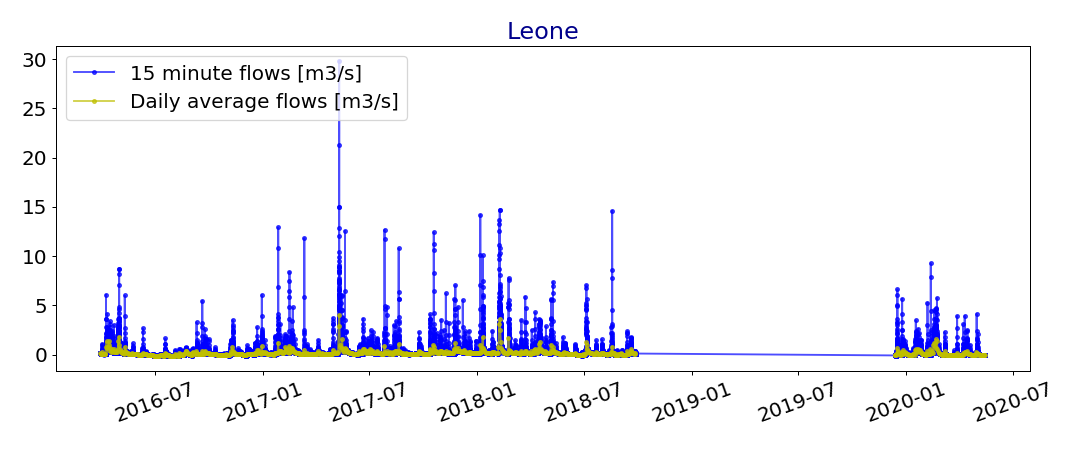

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


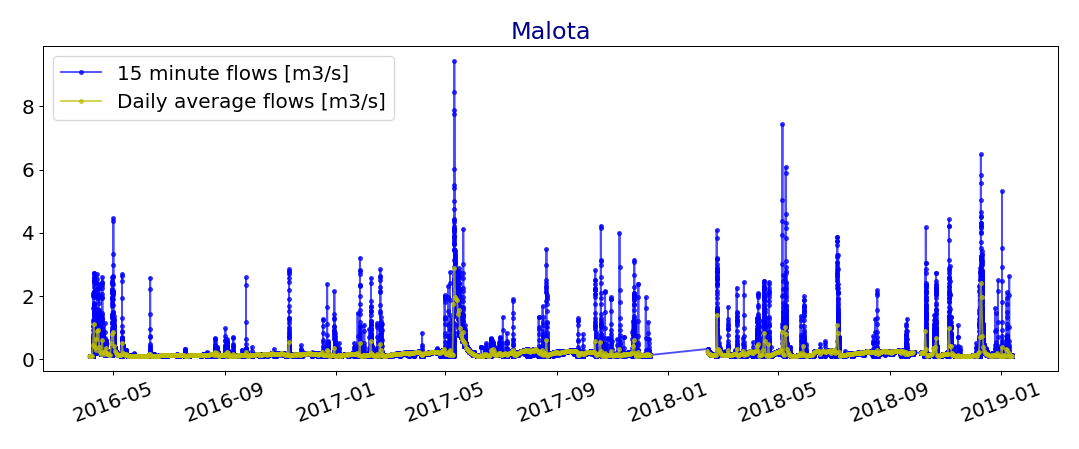

<IPython.core.display.Javascript object>

Fagaalu ave flow 7.362888367613441 CFS
Leone ave flow 7.277373933355769 CFS
Fagasa ave flow 4.0806581730121625 CFS
Afono ave flow 3.2125563231923584 CFS
Nuuuli ave flow 6.734856261810649 CFS
Vaipito ave flow 5.21926709437613 CFS
Malota ave flow 7.753786382818239 CFS
Fagaitua ave flow 1.020222277413388 CFS


In [36]:
plt.close("all")  # close previous figures to clear memory
# this subsamples the data into daily values

Curve_type =   '2d_poly_fit_Modeled_Q'    # 'Man_q_m3/sec'    or    'Power_law_Modeled_Q'       or        '2d_poly_fit_Modeled_Q'

master_day_flow = {}
for i in stream_stations:

    day_flow = All_masters_adjusted[i].set_index('Date and Time').resample('D').mean() 
    day_flow = day_flow.reset_index(drop=False)    
    master_day_flow[i] = day_flow

    fig = plt.figure(figsize=(12, 5))
    ax1 = plt.axes()
    ax1.set_title(i, color='darkblue')
    plt.plot(All_masters_adjusted[i]['Date and Time'], All_masters_adjusted[i][Curve_type], alpha = .7, color='b',  marker = '.', label = "15 minute flows [m3/s]")
    plt.plot(day_flow['Date and Time'], day_flow[Curve_type] , alpha = .7, color='y',  marker = '.', label = "Daily average flows [m3/s]")
    ax1.legend(loc=2)

    plt.xticks(rotation=20)
    plt.tight_layout()
    
Average_daily_flows = pd.DataFrame({'Date and Time':day_flow['Date and Time']}) # create empty dtaframe with random date column from above
Raws ={}                                                                        # duplicate daa storage formatting for baseflow separation below

for i in stream_stations: 
    Qs = master_day_flow[i][['Date and Time', Curve_type]].copy()
    keynam = i+"_CFS"
    Qs[keynam] = Qs[Curve_type]*35.314666212661                    # convert flow in m3/s to cfs
    del Qs[Curve_type]
    Average_daily_flows = Average_daily_flows.merge(Qs, how='outer', on='Date and Time')
    print("{} ave flow {} CFS".format(i, Qs[keynam].mean()))
         
    Qs = Qs.rename(index=str, columns={"Date and Time": "Date", keynam: "Total Flow (cfs)"})
    Raws[i] = Qs                                                               # duplicate daa storage formatting for baseflow separation below

Average_daily_flows = Average_daily_flows.sort_values('Date and Time')  # here is the sorted daily streamflow dataframe from all stations lined up on date NOTE USING Curve_type FROM ABOVE can change if want

# Baseflow separation 

Note this uses the Turning Point method, described in "U.S. Geological Survey Groundwater Toolbox, A Graphical and Mapping Interface for Analysis of Hydrologic Data (Version 1.0)—User Guide for Estimation of Base Flow, Runoff, and Groundwater Recharge From Streamflow Data,  
Pg. 2 explains the process and cites The BFI program (Wahl and Wahl, 1995) as the method used

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


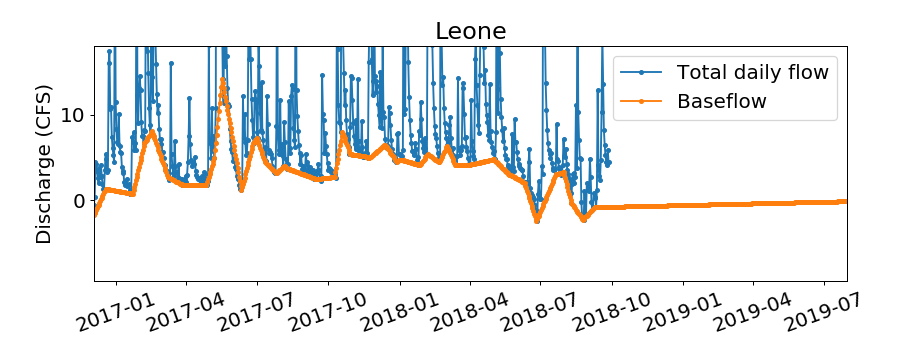

<IPython.core.display.Javascript object>


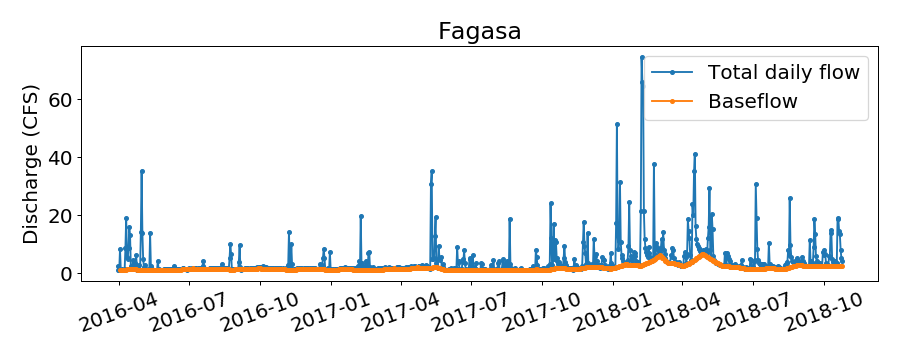

<IPython.core.display.Javascript object>


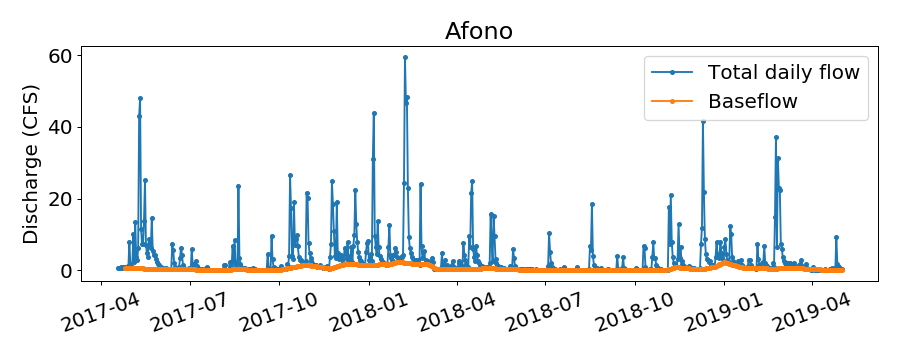

<IPython.core.display.Javascript object>


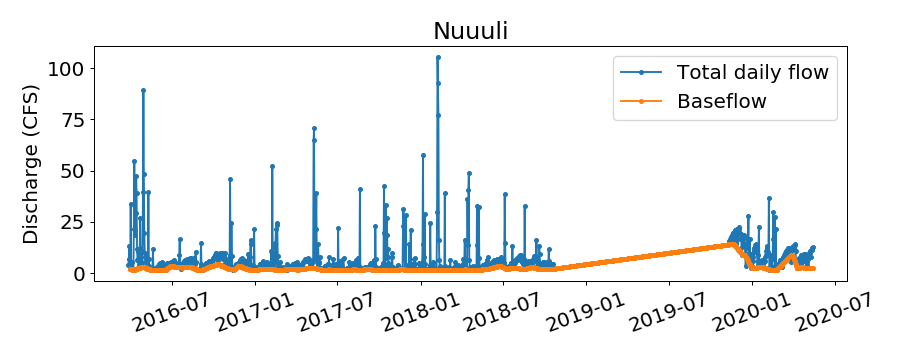

<IPython.core.display.Javascript object>


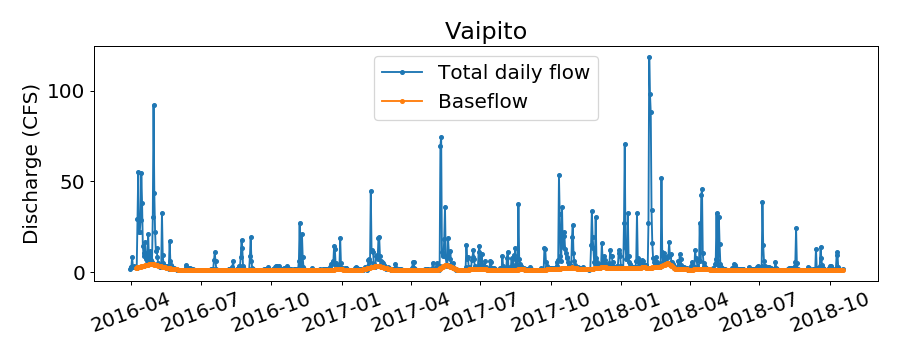

<IPython.core.display.Javascript object>


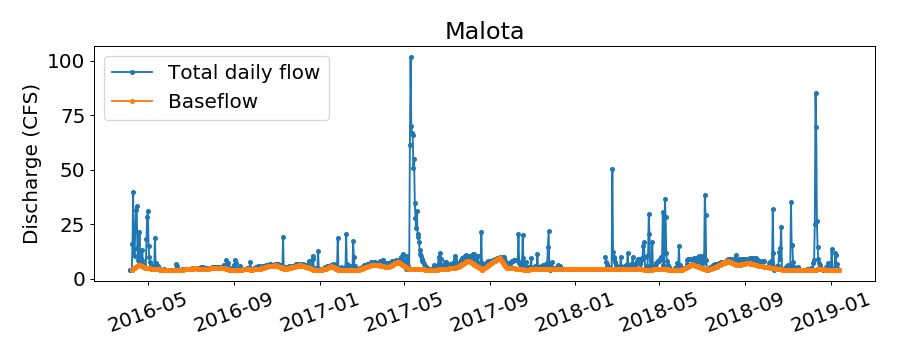

<IPython.core.display.Javascript object>

In [46]:
plt.close("all")  # close previous figures to clear memory

plot_units = "cfs" # options are "cfs" and "cms"    conversion is 35.314666212661 cfs to 1 cms

N = 5                     # averaging window, number of days
tp_test_factor = 0.9      # turning point test factor     (If 90 percent of a given minimum (the “turning point test factor”) is less than both adjacent minimums, then that minimum is a turning point.)

All_stations = {}                                                                           # eill be final processed dictionary of dataframes
Site=[]; SumTotal=[]; SumBF=[]; SumRO=[]; AveTotal=[]; AveBF=[]; AveRO=[]; BFTF=[]; ROTF=[]  # lists for sumary dataframe

for stato in stream_stations:
    mean_dates = []; mins = []; means = []
    for i in range(1,len(Raws[stato]['Date'])-N,N):                         # mikes code, still not sure I understand it all
        N_day_data = []
        for j in range(0,N-1):
            N_day_data.append(float(Raws[stato]['Total Flow (cfs)'][i+j]))
        mean_dates.append(Raws[stato]['Date'][i+(N//2)])
        mean_point = [Raws[stato]['Date'][i+(N//2)]]
        N_day_mean = np.mean(N_day_data)
        mean_point.append(N_day_mean)
        means.append(mean_point)
        min_point = [Raws[stato]['Date'][i+(N//2)]]
        N_day_min = np.min(N_day_data)
        min_point.append(N_day_min)
        mins.append(min_point)

    turning_points = []; tp_dates = []; tp_flow = []; sf_dates = []; sf_flow = [];     # mikes code, still not sure I understand it all
    for i in range(0,len(mins)-1,1):
        if (tp_test_factor*(mins[i][1]))<mins[i+1][1] and (tp_test_factor*(mins[i][1]))<mins[i-1][1]:
            turning_points.append(mins[i])
            tp_dates.append(mins[i][0])
            tp_flow.append(mins[i][1])

    Total_flows = pd.DataFrame({'Date': Raws[stato]['Date'], 'Total_flow_CFS': Raws[stato]['Total Flow (cfs)'] })
    Baseflows = pd.DataFrame({'Date': tp_dates, 'Base_flow_CFS': tp_flow })  
    All_flows = Total_flows.merge(Baseflows, how='outer', on='Date')                     # final dataframe with separated values of flow
    All_flows['Base_flow_CFS'].interpolate(inplace=True)                                 # baseflows were only calculated at turning points. here linearly interpolate to give a value for each day
    All_flows['Runoff_CFS'] = All_flows['Total_flow_CFS'] - All_flows['Base_flow_CFS']
    All_flows['Runoff_CFS'] = All_flows['Runoff_CFS'].clip(lower=0)    # convert any negative runoff values to zero
    
    All_stations[stato] = All_flows                      # create final dictionary                            
    
    # all this to create the summary dataframe for comparison
    Site.append(stato); SumTotal.append(All_flows['Total_flow_CFS'].sum()); SumBF.append(All_flows['Base_flow_CFS'].sum()); SumRO.append(All_flows['Total_flow_CFS'].sum()-All_flows['Base_flow_CFS'].sum())
    AveTotal.append(All_flows['Total_flow_CFS'].mean()); AveBF.append(All_flows['Base_flow_CFS'].mean()); AveRO.append(All_flows['Total_flow_CFS'].mean()-All_flows['Base_flow_CFS'].mean())
    BFTF.append((All_flows['Base_flow_CFS'].mean()/All_flows['Total_flow_CFS'].mean()))
    
    # plot stuff
    fig, ax = plt.subplots(figsize=(10, 4))
    
    if plot_units == "cfs": 
        ax.plot(All_flows['Date'],All_flows['Total_flow_CFS'], '-',label='Total daily flow', marker='.')
        ax.plot(All_flows['Date'],All_flows['Base_flow_CFS'], '-',label='Baseflow', marker='.')
        plt.ylabel('Discharge (CFS)')
    if plot_units == "cms": 
        ax.plot(All_flows['Date'],All_flows['Total_flow_CFS']/35.3147, '-',label='Total daily flow', marker='.')
        ax.plot(All_flows['Date'],All_flows['Base_flow_CFS']/35.3147, '-',label='Baseflow', marker='.')
        plt.ylabel('Discharge (m3/sec)')
    
    ax.set_title(stato)
    ax.legend()
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, "Figures", "Stream", f"Processed_streamflow_{plot_units}_{stato}.png")) # Can switch to pdf too

### OUTPUT production,  streamflow statistics, daily, yearly, and monthly

In [67]:
#### Annual summary dataframe   ####
Annual_stats_all = pd.DataFrame({'Site':Site,'Ave_Total_Q_[cfs]':AveTotal,'AveBF_[cfs]':AveBF,'Ave RO_[cfs]':AveRO,'BF:Q':BFTF})
# save a csv of the annual stats 
Annual_stats_all.to_csv(os.path.join(results_path, 'Processed_streamflow_data', "Annual_UH-ASPA_streamflows.csv"))


#### Daily resolution output ##### 
# print out a daily streamflow CSV for each station
for i in All_stations.keys():
    All_stations[i].to_csv(os.path.join(results_path, 'Processed_streamflow_data', 'daily', f"{i}_Daily_streamflowCFS.csv"))

# And a single file with all stations on one
Average_daily_flows.to_csv(os.path.join(results_path, 'Processed_streamflow_data', 'daily', 'ALL_stations_Daily_flow.csv'), index=False)

#### Monthly by station ####   
# Consolidate by a dictionary of stations {Station_stats} with an entry for each month
Station_stats ={}
for stato in stream_stations:
    All_stations[stato]['Month'] = All_stations[stato]['Date'].apply(lambda i: i.month)
    M = []; TF_sum = []; BF_sum =[]; RO_sum = []
    for i in All_stations[stato]['Month'].unique():
        a = All_stations[stato][All_stations[stato]['Month'] == i]
        tf = a['Total_flow_CFS'].mean()
        bf = a['Base_flow_CFS'].mean()
        ro = a['Runoff_CFS'].mean()
        M.append(i); TF_sum.append(tf); BF_sum.append(bf); RO_sum.append(ro)
    tica  = pd.DataFrame({'Month':M,'Total_flow':TF_sum,'Baseflow':BF_sum, 'Runoff':RO_sum,})
    tica['BF:TF'] = tica['Baseflow']/tica['Total_flow']
    tica['Site'] = stato
    Station_stats[stato] = tica
    tica.sort_values('Month').to_csv(os.path.join(results_path, 'Processed_streamflow_data', 'monthly', "by_station", f"{stato}_MonthlyAve_flowCFS.csv"))    # SAve csvs
    
    
# Consolidate by a dictionary of months  {Monthly_stats} with an entry for each station
Monthly_stats = {}
month_key = {1:'January',  2:'February',  3:'March',  4:'April',  5:'May',  6:'June',  7:'July',  8:'August',  9:'September',  10:'October',  11:'November',  12:'December'}
for m in range(1,13):
    mogo = pd.DataFrame()
    for s in stream_stations:
        lineo = Station_stats[s][Station_stats[s]['Month'] == m]
        mogo = pd.concat([mogo, lineo], axis=0)
    Monthly_stats[month_key[m]] = mogo
# print out a monthly average streamflow CSV for each month
for m in Monthly_stats.keys():
    Monthly_stats[m].to_csv(os.path.join(results_path, 'Processed_streamflow_data', 'monthly', "by_month", f"{m}_MonthlyAve_flowCFS_allstation.csv"))

### Consolidate all 15MIN  data into single spreadsheet lined up by date

In [72]:
minlist = []; maxlist = []
for i in All_masters_adjusted.keys():
    
    ismall = All_masters_adjusted[i]['Date and Time'].min()
    ibig   = All_masters_adjusted[i]['Date and Time'].max()
    
    minlist.append(ismall)
    maxlist.append(ibig)
        
end = max(maxlist)
start = min(minlist)


#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
Bigdatelist = []
for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval  
    Bigdatelist.append(dt)                              # stick each interval object onto a list 
labels = ['DateTime']                                  #define column name for dataframe
All_station_dates = pd.DataFrame(Bigdatelist, columns=labels)    # Make our list into a pd dataframe

All_merged = pd.DataFrame(columns = ["DateTime"], data = All_station_dates)

# format each station data to merge together
tempdic = {}
for i in All_masters_adjusted.keys():
    tempframe = All_masters_adjusted[i][['Date and Time', '2d_poly_fit_Modeled_Q']]
    tempframe = tempframe.rename(columns={"Date and Time": "DateTime", '2d_poly_fit_Modeled_Q':'{}_m3ps'.format(i)})
    tempdic[i] = tempframe

#merge all the datasets into one massive dataset
for m in tempdic.keys():
    All_merged = All_merged.merge(tempdic[m], how='outer', on='DateTime')

All_merged.to_csv(os.path.join(results_path, 'Processed_streamflow_data', 'ALL_15min_Q_m3ps.csv'), index=False)

<IPython.core.display.Javascript object>


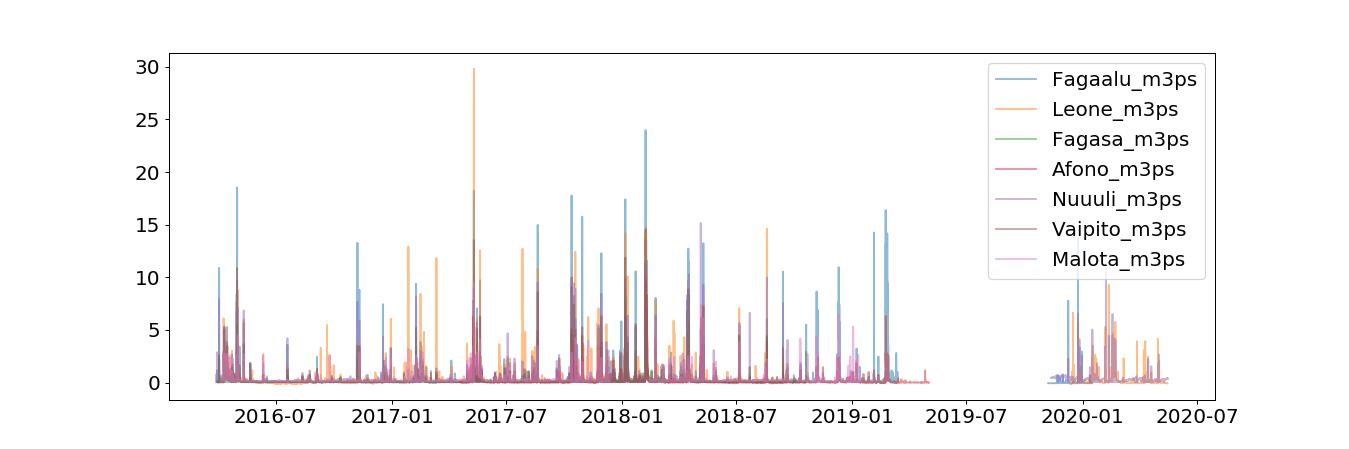

In [71]:
#plot ALL Data 
fig = plt.figure(figsize=(15, 5))
ax1 = plt.axes()
for t in All_merged.columns[1:-1]: 
        ax1.plot(All_merged['DateTime'], All_merged[t], alpha = .7, marker='', label=t )
        plt.legend()

In [ ]:

# Note might need to add this if the index column in any of the raw data csvs is missing the # in the heading 

#If there is an issue with there being wrong date and time columns....

# This little code block was just added to dea with a formatting issue with the date and time column, apparently some of the files have it in one, and some have it in two
        if np.isfinite(x['temp'].iloc[2]):
            x['Date_tmp'] = pd.to_datetime(x['Date and Time'] + ' ' + x['time'])
            x['Date and Time'] = x['Date_tmp']
            del x['Date_tmp']
            del x['time'] 

        else:
            del x['temp']
            x = x.rename(columns={'time': 'psi', 'psi': 'temp'})
            x['Date and Time'] = pd.to_datetime(x['Date and Time'], errors='coerce')
        